# Infer CanglongV1

In [1]:
demo_start_time = '2025-09-17'
demo_end_time = '2025-09-30'
data_inner_steps = 24
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcsfs
import zarr
import xarray
# 设置滚动预报的周数
forecast_weeks = 6  # 预测未来6周

# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

surface_var_names = [
    'large_scale_rain_rate',
    'convective_rain_rate',
    'total_column_cloud_ice_water',
    'total_cloud_cover',
    'top_net_solar_radiation_clear_sky',
    '10m_u_component_of_wind',
    '10m_v_component_of_wind',
    '2m_dewpoint_temperature',
    '2m_temperature',
    'surface_latent_heat_flux',
    'surface_sensible_heat_flux',
    'surface_pressure',
    'volumetric_soil_water_layer',
    'mean_sea_level_pressure',
    'sea_ice_cover',
    'sea_surface_temperature'
]

# 变量统计信息
ordered_var_stats = {
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'sst': {'mean': 189.7337189, 'std': 136.1803131},
    
    # 高空层变量（按新顺序排列）
    'geopotential': {
        '300': {'mean': 13763.50879, 'std': 1403.990112},
        '500': {'mean': 28954.94531, 'std': 2085.838867},
        '700': {'mean': 54156.85547, 'std': 3300.384277},
        '850': {'mean': 89503.79688, 'std': 5027.79541}
    },
    'vertical_velocity': {
        '300': {'mean': 0.011849277, 'std': 0.126232564},
        '500': {'mean': 0.002759292, 'std': 0.097579598},
        '700': {'mean': 0.000348145, 'std': 0.072489716},
        '850': {'mean': 0.000108061, 'std': 0.049831692}
    },
    'u_component_of_wind': {
        '300': {'mean': 1.374536991, 'std': 6.700420856},
        '500': {'mean': 3.290786982, 'std': 7.666454315},
        '700': {'mean': 6.491596222, 'std': 9.875613213},
        '850': {'mean': 11.66026878, 'std': 14.00845909}
    },
    'v_component_of_wind': {
        '300': {'mean': 0.146550566, 'std': 3.75399971},
        '500': {'mean': 0.022800878, 'std': 4.179731846},
        '700': {'mean': -0.025720235, 'std': 5.324173927},
        '850': {'mean': -0.027837994, 'std': 7.523460865}
    },
    'fraction_of_cloud_cover': {
        '300': {'mean': 0.152513072, 'std': 0.15887706},
        '500': {'mean': 0.106524825, 'std': 0.144112185},
        '700': {'mean': 0.105878539, 'std': 0.112193666},
        '850': {'mean': 0.108120449, 'std': 0.108371623}
    },
    'temperature': {
        '300': {'mean': 274.8048401, 'std': 15.28209305},
        '500': {'mean': 267.6254578, 'std': 14.55300999},
        '700': {'mean': 253.1627655, 'std': 12.77071381},
        '850': {'mean': 229.0860138, 'std': 10.5536499}
    },
    'specific_humidity': {
        '300': {'mean': 0.004610791, 'std': 0.003879665},
        '500': {'mean': 0.002473272, 'std': 0.002312181},
        '700': {'mean': 0.000875093, 'std': 0.000944978},
        '850': {'mean': 0.000130984, 'std': 0.000145811}
    }
}


In [2]:
ds_surface = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    consolidated=True
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',\
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]
surface_full_19_1day = ds_surface.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
surface_full_19_1day.load()
surface_full_19_1day['volumetric_soil_water_layer'] = (
    surface_full_19_1day['volumetric_soil_water_layer_1'] + 
    surface_full_19_1day['volumetric_soil_water_layer_2'] + 
    surface_full_19_1day['volumetric_soil_water_layer_3'] + 
    surface_full_19_1day['volumetric_soil_water_layer_4']
)

In [ ]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = surface_full_19_1day.isel(time=slice(0, 7))  # 前7天
week2_data = surface_full_19_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))



surface_input_weekly_means = weekly_means[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer', \
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

stacked_data = xr.concat([surface_input_weekly_means[var] for var in surface_input_weekly_means.data_vars], 
                         dim=xr.DataArray(list(surface_input_weekly_means.data_vars), dims='variable'))


# 准备均值和标准差数组，形状为(16,1,1,1)，可以广播到(16,2,721,1440)
means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_input_weekly_means.data_vars])
stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_input_weekly_means.data_vars])

# 重塑形状用于广播
means = means.reshape(-1, 1, 1, 1)
stds = stds.reshape(-1, 1, 1, 1)

normalized_input_surface = (stacked_data.values - means) / stds
normalized_input_surface = np.nan_to_num(normalized_input_surface, nan=0.0)

In [4]:
ds_upper_air = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    consolidated=True,
    chunks=None
)[['geopotential', 'vertical_velocity', 'u_component_of_wind', 'v_component_of_wind', 'fraction_of_cloud_cover', 'temperature', 'specific_humidity']]

# Select only pressure levels 300, 500, 700, 850 hPa
selected_levels = [300, 500, 700, 850]
ds_upper_air = ds_upper_air.sel(level=selected_levels)

upper_air_full_7_1day = ds_upper_air.sel(time=slice(demo_start_time, demo_end_time, 24))
upper_air_full_7_1day.load()

<xarray.Dataset> Size: 2GB
Dimensions:                  (time: 14, level: 4, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * level                    (level) int64 32B 300 500 700 850
  * longitude                (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                     (time) datetime64[ns] 112B 2025-09-17 ... 2025-0...
Data variables:
    geopotential             (time, level, latitude, longitude) float32 233MB ...
    vertical_velocity        (time, level, latitude, longitude) float32 233MB ...
    u_component_of_wind      (time, level, latitude, longitude) float32 233MB ...
    v_component_of_wind      (time, level, latitude, longitude) float32 233MB ...
    fraction_of_cloud_cover  (time, level, latitude, longitude) float32 233MB ...
    temperature              (time, level, latitude, longitude) float32 233MB ...
    specific_humidity        (time, level, latitude, longitude) float32 233MB ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-10-02 01:54:14.170756+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-26

In [5]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = upper_air_full_7_1day.isel(time=slice(0, 7))  # 前7天
week2_data = upper_air_full_7_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
upper_air_weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))

# 按照指定的变量顺序
upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

# 选择指定顺序的变量
upper_air_weekly_means = upper_air_weekly_means[upper_air_vars]

# 准备标准化
# 首先将数据转换为方便处理的格式
var_level_data = []
means = []
stds = []

# 对每个变量和每个气压层级，获取数据和对应的统计值
for var in upper_air_vars:
    for level in upper_air_weekly_means.level.values:
        level_str = str(level.item())
        
        # 获取该变量和层级的数据
        data = upper_air_weekly_means[var].sel(level=level)
        var_level_data.append(data)
        
        # 获取该变量和层级的均值和标准差
        means.append(ordered_var_stats[var][level_str]['mean'])
        stds.append(ordered_var_stats[var][level_str]['std'])

# 将数据合并到一个xarray数据集中
stacked_data_upper = xr.concat(var_level_data, 
                              dim=xr.DataArray([f"{var}_{level.item()}" for var in upper_air_vars 
                                               for level in upper_air_weekly_means.level.values], 
                                              dims='var_level'))

# 转换为numpy数组进行标准化
data_array = stacked_data_upper.values  # 形状为 (28, 2, 721, 1440) - 7变量×4层级×2周×格点数据

# 将均值和标准差转换为适合广播的形状
means_array = np.array(means).reshape(-1, 1, 1, 1)
stds_array = np.array(stds).reshape(-1, 1, 1, 1)

# 使用广播进行标准化
normalized_data = (data_array - means_array) / stds_array

normalized_input_upper_air = normalized_data.reshape(len(upper_air_vars), len(upper_air_weekly_means.level), 
                                              len(upper_air_weekly_means.week), 
                                              len(upper_air_weekly_means.latitude), 
                                              len(upper_air_weekly_means.longitude))

In [5]:
var_mapping = {
    'large_scale_rain_rate': 'lsrr',
    'convective_rain_rate': 'crr',
    'total_column_cloud_ice_water': 'tciw',
    'total_cloud_cover': 'tcc',
    'top_net_solar_radiation_clear_sky': 'tsrc',
    '10m_u_component_of_wind': 'u10',
    '10m_v_component_of_wind': 'v10',
    '2m_dewpoint_temperature': 'd2m',
    '2m_temperature': 't2m',
    'surface_latent_heat_flux': 'surface_latent_heat_flux',
    'surface_sensible_heat_flux': 'surface_sensible_heat_flux',
    'surface_pressure': 'sp',
    'volumetric_soil_water_layer': 'swvl',
    'mean_sea_level_pressure': 'msl',
    'sea_ice_cover': 'siconc',
    'sea_surface_temperature': 'sst'
}

In [2]:
import numpy as np
# np.save('normalized_input_upper_air.npy', normalized_input_upper_air)
# np.save('normalized_input_surface.npy', normalized_input_surface)
normalized_input_upper_air = np.load('normalized_input_upper_air.npy')
normalized_input_surface = np.load('normalized_input_surface.npy')

In [6]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')  # 添加上一级目录到路径
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed_old import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D  
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
input_constant = torch.load('../constant_masks/input_tensor.pt').cuda()

class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
import torch
import torch.nn as nn
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class Canglong(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=16, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(4, 181, 360), output_resolution=(4, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (4, 91, 180), (4, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=16, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 4, 721, 1440), 
                                               patch_size=(4, 2, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7)
        self.conv_constant = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):
        
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        

        x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)

        output_surface = output[:, :, 2:, :, :]
        output_upper_air = output[:, :, 0, :, :]

        #output_surface = self.patchrecovery3d(output_surface)
        output_surface = self.decoder3d(output_surface)

        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(2).unsqueeze(3))

        return output_surface, output_upper_air

import torch
import numpy as np

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 假设已经有标准化后的输入数据
# normalized_input_surface: (16, 2, 721, 1440) - [变量, 周数, 纬度, 经度]
# normalized_input_upper_air: (7, 4, 2, 721, 1440) - [变量, 层级, 周数, 纬度, 经度]

# 转换为PyTorch张量
input_surface_tensor = torch.tensor(normalized_input_surface, dtype=torch.float32).unsqueeze(0)  # 添加批次维度
input_upper_air_tensor = torch.tensor(normalized_input_upper_air, dtype=torch.float32).unsqueeze(0)  # 添加批次维度

print(f"地表输入数据形状: {input_surface_tensor.shape}")  # 应为 [1, 16, 2, 721, 1440]
print(f"高空输入数据形状: {input_upper_air_tensor.shape}")  # 应为 [1, 7, 4, 2, 721, 1440]
import sys                                                                                  
import canglong.embed_old as embed_old                                                                                                                                                
sys.modules['canglong.embed'] = embed_old
import canglong.recovery_old as recovery_old
sys.modules['canglong.recovery'] = recovery_old
# 加载模型
model_path = '/home/lhwang/Desktop/model/model_epoch_500.pt'  # 使用最佳模型
print(f"正在从 {model_path} 加载模型...")
model = torch.load('F:/model/weather_model_epoch_500.pt', map_location=device, weights_only=False)

model.to(device)
model.eval()
print("模型加载成功")

# 设置预测的周数
forecast_weeks = 6

# 将数据移动到设备
current_input_surface = input_surface_tensor.to(device)
current_input_upper_air = input_upper_air_tensor.to(device)

# 存储滚动预报的结果
all_surface_predictions = []
all_upper_air_predictions = []

print(f"开始 {forecast_weeks} 周滚动预报...")

with torch.no_grad():
    # 滚动预报指定周数
    for week in range(forecast_weeks):
        # 前向传播
        output_surface, output_upper_air = model(current_input_surface, current_input_upper_air)
        
        # 存储当前周的预测结果
        all_surface_predictions.append(output_surface[:, :, 0:1, :, :])  # 只取第一个时间步
        all_upper_air_predictions.append(output_upper_air[:, :, :, 0:1, :, :])  # 只取第一个时间步
        
        print(f"完成第 {week+1} 周预测")
        
        if week < forecast_weeks - 1:  # 如果不是最后一周，准备下一周的输入
            # 更新输入：使用上一个时间步和新预测的时间步
            new_input_surface = torch.cat([
                current_input_surface[:, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_surface[:, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=2)
            
            new_input_upper_air = torch.cat([
                current_input_upper_air[:, :, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_upper_air[:, :, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=3)
            
            current_input_surface = new_input_surface
            current_input_upper_air = new_input_upper_air

# 合并所有周的预测结果
all_weeks_surface_predictions = torch.cat(all_surface_predictions, dim=2)  # [1, 16, forecast_weeks, 721, 1440]
all_weeks_upper_air_predictions = torch.cat(all_upper_air_predictions, dim=3)  # [1, 7, 4, forecast_weeks, 721, 1440]

print(f"滚动预报完成。")
print(f"所有周的地表预测形状: {all_weeks_surface_predictions.shape}")
print(f"所有周的高空预测形状: {all_weeks_upper_air_predictions.shape}")
# 将预测结果移回CPU并转换为numpy数组
surface_predictions_np = all_weeks_surface_predictions.cpu().numpy()
upper_air_predictions_np = all_weeks_upper_air_predictions.cpu().numpy()



print("可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果")
print("完成推理过程")


使用设备: cuda:0
地表输入数据形状: torch.Size([1, 16, 2, 721, 1440])
高空输入数据形状: torch.Size([1, 7, 4, 2, 721, 1440])
正在从 /home/lhwang/Desktop/model/model_epoch_500.pt 加载模型...
模型加载成功
开始 6 周滚动预报...
完成第 1 周预测
完成第 2 周预测
完成第 3 周预测
完成第 4 周预测
完成第 5 周预测
完成第 6 周预测
滚动预报完成。
所有周的地表预测形状: torch.Size([1, 16, 6, 721, 1440])
所有周的高空预测形状: torch.Size([1, 7, 4, 6, 721, 1440])
可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果
完成推理过程


In [7]:
# 准备地表数据的均值和标准差数组，形状为(16,1,1,1)
surface_means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_var_names])
surface_stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_var_names])

# 重塑形状用于广播 - 注意增加了一个维度用于周数
surface_means = surface_means.reshape(-1, 1, 1, 1)
surface_stds = surface_stds.reshape(-1, 1, 1, 1)

# 使用广播一次性反标准化所有地表数据
denormalized_surface = surface_predictions_np * surface_stds + surface_means

In [8]:
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

def data_to_xarray(denormalized_surface, demo_start_time='2025-02-01', demo_end_time='2025-02-14', forecast_weeks=6):
    """
    将反标准化的地表数据转换为xarray数据集，并计算预测时间点
    
    参数:
        denormalized_surface: 形状为(16, forecast_weeks, 721, 1440)的反标准化地表数据
        demo_start_time: 演示起始时间，格式为'YYYY-MM-DD'
        demo_end_time: 演示结束时间，格式为'YYYY-MM-DD'
        forecast_weeks: 预测的周数
    
    返回:
        surface_ds: 地表数据xarray数据集
    """
    # 定义变量名称
    surface_var_names = [
        'large_scale_rain_rate',
        'convective_rain_rate',
        'total_column_cloud_ice_water',
        'total_cloud_cover',
        'top_net_solar_radiation_clear_sky',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        '2m_dewpoint_temperature',
        '2m_temperature',
        'surface_latent_heat_flux',
        'surface_sensible_heat_flux',
        'surface_pressure',
        'volumetric_soil_water_layer',
        'mean_sea_level_pressure',
        'sea_ice_cover',
        'sea_surface_temperature'
    ]
    
    # 解析起始和结束时间
    start_date = datetime.strptime(demo_start_time, '%Y-%m-%d')
    end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
    
    # 计算预测时间点
    # 假设end_date是第二周的结束日期，我们从第三周开始预测
    forecast_start_date = end_date + timedelta(days=1)  # 从结束日期的下一天开始预测
    
    # 计算每个预测周的日期（取每周的最后一天）
    forecast_dates = []
    for i in range(forecast_weeks):
        # 每周结束日期 = 预测开始日期 + (i+1)*7 - 1 天
        week_end_date = forecast_start_date + timedelta(days=(i+1)*7-1)
        forecast_dates.append(week_end_date)
    
    # 创建坐标
    lat = np.linspace(90, -90, 721)
    lon = np.linspace(0, 359.75, 1440)
    
    # 创建地表数据的xarray数据集
    surface_ds = xr.Dataset(coords={
        'variable': surface_var_names,
        'time': forecast_dates,
        'latitude': lat,
        'longitude': lon
    })
    
    # 使用DataArray存储所有数据
    surface_data_array = xr.DataArray(
        denormalized_surface,
        dims=['variable', 'time', 'latitude', 'longitude'],
        coords={
            'variable': surface_var_names, 
            'time': forecast_dates, 
            'latitude': lat, 
            'longitude': lon
        }
    )
    
    # 将DataArray添加到Dataset中
    surface_ds['data'] = surface_data_array
    
    # 为每个变量创建单独的数据变量
    for i, var_name in enumerate(surface_var_names):
        surface_ds[var_name] = surface_data_array.sel(variable=var_name)
    
    # 计算总降水率并添加到数据集
    surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']
    
    # 添加预测周信息作为属性
    surface_ds.attrs['forecast_start_date'] = forecast_start_date.strftime('%Y-%m-%d')
    surface_ds.attrs['forecast_end_date'] = forecast_dates[-1].strftime('%Y-%m-%d')
    surface_ds.attrs['prediction_type'] = f"{forecast_weeks}-Week Forecast"
    surface_ds.attrs['input_data_period'] = f"{demo_start_time} to {demo_end_time}"
    
    return surface_ds

# 使用示例

# 假设我们已经有了反标准化的数据

forecast_weeks = 6

# 转换为xarray数据集
surface_ds = data_to_xarray(
    denormalized_surface[0], 
    demo_start_time=demo_start_time,
    demo_end_time=demo_end_time,
    forecast_weeks=forecast_weeks
)


print("预测时间范围:", surface_ds.attrs['forecast_start_date'], "至", surface_ds.attrs['forecast_end_date'])

import ftplib
import os
from io import BytesIO
import xarray as xr

def upload_to_ftp(ftp_host, ftp_user, ftp_password, local_file_path, ftp_directory):
    """
    将文件上传到FTP服务器
    
    Parameters:
    -----------
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    local_file_path : str
        本地文件路径
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 连接到FTP服务器
        ftp = ftplib.FTP(ftp_host)
        ftp.login(user=ftp_user, passwd=ftp_password)
        
        # 切换到目标目录
        ftp.cwd(ftp_directory)
        
        # 获取文件名
        filename = os.path.basename(local_file_path)
        
        # 上传文件
        with open(local_file_path, 'rb') as file:
            ftp.storbinary(f'STOR {filename}', file)
        
        print(f"File {filename} uploaded successfully to {ftp_directory}")
        
        # 关闭FTP连接
        ftp.quit()
        return True
        
    except Exception as e:
        print(f"Error uploading file: {e}")
        return False

def save_and_upload_dataset(dataset, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory):
    """
    将数据集保存到本地并上传到FTP服务器
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        要保存的数据集
    local_file_path : str
        本地保存路径（包含文件名）
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 确保目标目录存在
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        
        # 保存数据集到本地文件
        dataset.to_netcdf(local_file_path)
        print(f"File saved locally to {local_file_path}")
        
        # 上传到FTP
        success = upload_to_ftp(
            ftp_host=ftp_host,
            ftp_user=ftp_user,
            ftp_password=ftp_password,
            local_file_path=local_file_path,
            ftp_directory=ftp_directory
        )
        
        return success
        
    except Exception as e:
        print(f"Error saving and uploading file: {e}")
        return False

# 使用示例
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG"
ftp_password = "123456789"  # 请替换为实际的密码

#示例1：保存surface数据
local_file_path = os.path.join('Z:/Data/temp', f"canglong_6weeks_{surface_ds.attrs['forecast_start_date']}_{surface_ds.attrs['forecast_end_date']}.nc")
ftp_directory = '/Projects/data_NRT/Canglong'
success = save_and_upload_dataset(surface_ds, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory)

预测时间范围: 2025-10-01 至 2025-11-11
File saved locally to Z:/Data/temp\canglong_6weeks_2025-10-01_2025-11-11.nc
File canglong_6weeks_2025-10-01_2025-11-11.nc uploaded successfully to /Projects/data_NRT/Canglong


In [9]:
import xarray as xr
import numpy as np

# Open the dataset
temp = xr.open_dataset('E:/data/temp.nc', engine='netcdf4')
climate = xr.open_dataset('E:/data/climate_variables_2000_2023_weekly.nc')

import xarray as xr
import pandas as pd

demo_start = (pd.to_datetime(demo_start_time) - pd.Timedelta(days=7)).strftime('%Y-%m-%d')

data_inner_steps = 24
ds_surface = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    consolidated=True
)[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]
surface_ds_former = ds_surface.sel(time=slice(demo_start, demo_end_time, data_inner_steps))
surface_ds_former.load()

# 更简单的方法：由于数据恰好是3周，直接分成三个7天
week1_data = surface_ds_former.isel(time=slice(0, 7))    # 第1-7天
week2_data = surface_ds_former.isel(time=slice(7, 14))   # 第8-14天
week3_data = surface_ds_former.isel(time=slice(14, 21))  # 第15-21天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')
week3_mean = week3_data.mean(dim='time')

# 合并为一个新的数据集，包含三周的平均值
ds_former_means = xr.concat([week1_mean, week2_mean, week3_mean], 
                         dim=pd.DatetimeIndex([
                             pd.to_datetime(week1_data.time.values[0]),
                             pd.to_datetime(week2_data.time.values[0]),
                             pd.to_datetime(week3_data.time.values[0])
                         ], name='time'))

# 加载预测数据集
import xarray as xr
from datetime import datetime, timedelta

# 计算文件名的起止时间
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date = end_date + timedelta(days=1)
end_date = end_date + timedelta(weeks=6)

# 构建文件名
filename = f'Z:/Data/temp/canglong_6weeks_{start_date.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc'

# 加载数据集
surface_ds = xr.open_dataset(filename)
surface_ds[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]
combined_ds = xr.concat(
    [ds_former_means, surface_ds[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]],
    dim='time'
)

# 加载预测数据集
import xarray as xr
surface_ds = combined_ds

# 处理温度数据 - 从开尔文转换为摄氏度
surface_ds['2m_temperature'] = surface_ds['2m_temperature'] - 273.15
surface_ds['2m_dewpoint_temperature'] = surface_ds['2m_dewpoint_temperature'] - 273.15

# 处理降水数据 - 从 m/hr 转换为 mm/day
precip_vars = ['large_scale_rain_rate', 'convective_rain_rate']
m_hr_to_mm_day_factor = 24.0 * 1000.0
for var in precip_vars:
    if var in surface_ds:
        surface_ds[var] = surface_ds[var].where(surface_ds[var] >= 0, 0)
        surface_ds[var] = surface_ds[var] * m_hr_to_mm_day_factor



surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']


t2m_celsius = surface_ds['2m_temperature'].values
d2m_celsius = surface_ds['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
surface_ds['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

# 使用列表语法正确提取多个变量
ds_sub = surface_ds[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]

File saved locally to Z:/Data/temp/spei1_forecast_2025-10-01_2025-11-11.nc
File spei1_forecast_2025-10-01_2025-11-11.nc uploaded successfully to /Projects/data_NRT/Canglong
Figure saved locally to Z:/Data/temp\spei1_forecast_2025-10-01_2025-11-11.png
File spei1_forecast_2025-10-01_2025-11-11.png uploaded successfully to /Projects/data_NRT/Canglong/figure


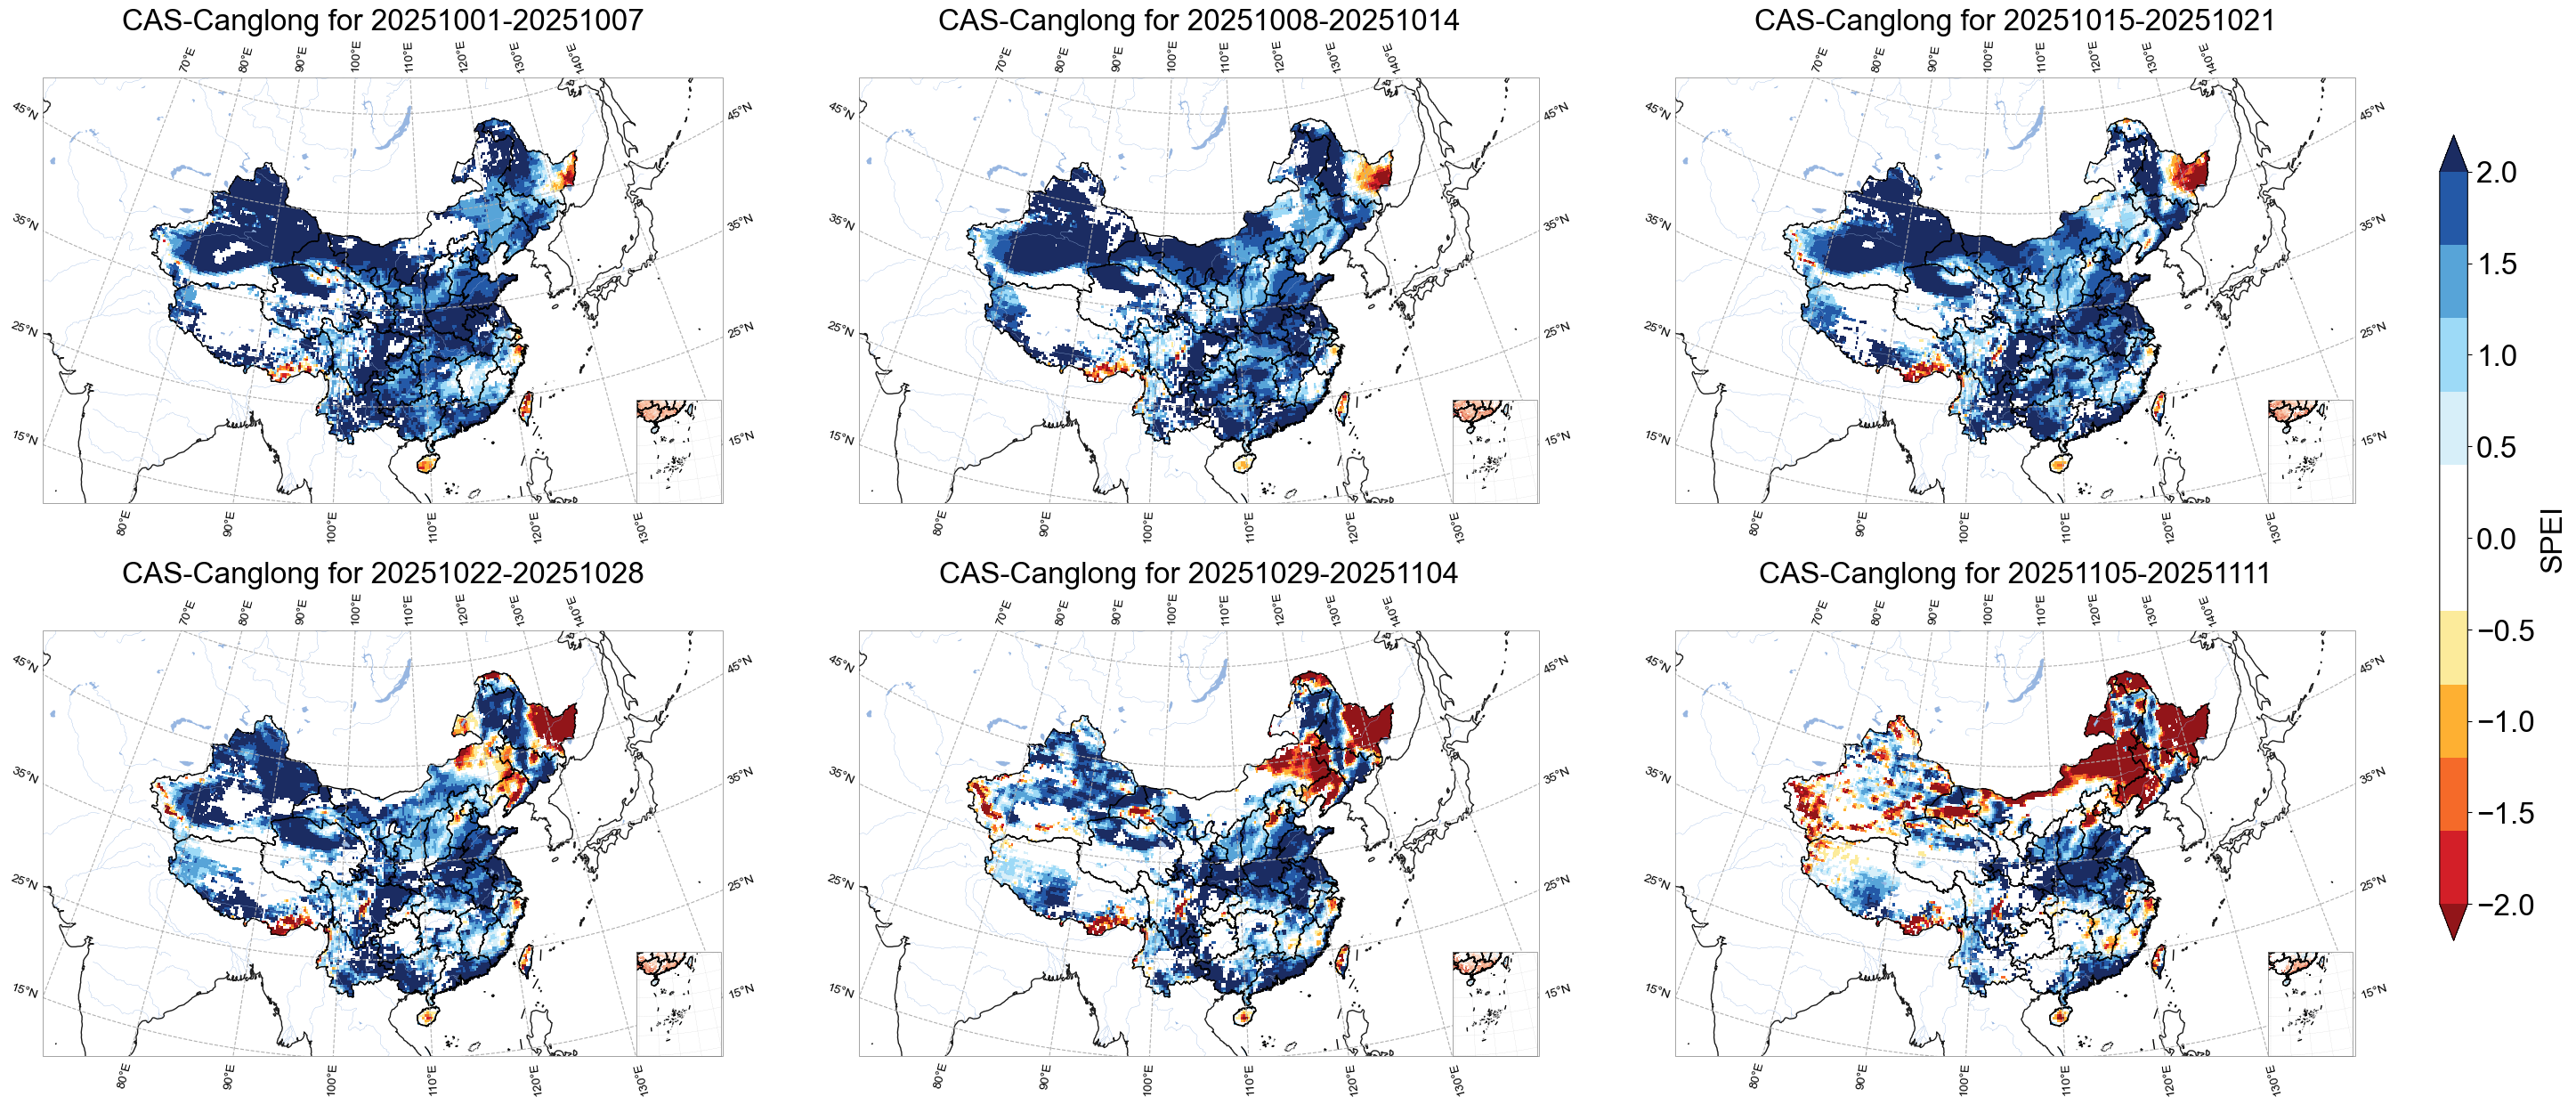

In [10]:
## 拟合函数SPEI
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_function
import pandas as pd

def calculate_pwm(series):
    n = len(series)
    if n < 3:
        return np.nan, np.nan, np.nan

    sorted_series = np.sort(series)
    F_vals = (np.arange(1, n + 1) - 0.35) / n
    one_minus_F = 1.0 - F_vals

    W0 = np.mean(sorted_series)
    W1 = np.sum(sorted_series * one_minus_F) / n
    W2 = np.sum(sorted_series * (one_minus_F**2)) / n
    
    return W0, W1, W2

def calculate_loglogistic_params(W0, W1, W2):
    if np.isnan(W0) or np.isnan(W1) or np.isnan(W2):
        return np.nan, np.nan, np.nan

    numerator_beta = (2 * W1) - W0
    denominator_beta = (6 * W1) - W0 - (6 * W2)
    
    if np.isclose(denominator_beta, 0):
        return np.nan, np.nan, np.nan 
    beta = numerator_beta / denominator_beta

    if beta <= 1.0:
        return np.nan, np.nan, np.nan

    try:
        term_gamma1 = gamma_function(1 + (1 / beta))
        term_gamma2 = gamma_function(1 - (1 / beta))
    except ValueError:
        return np.nan, np.nan, np.nan

    denominator_alpha = term_gamma1 * term_gamma2
    if np.isclose(denominator_alpha, 0):
        return np.nan, np.nan, np.nan
        
    alpha = ((W0 - (2 * W1)) * beta) / denominator_alpha
    
    if alpha <= 0:
        return np.nan, np.nan, np.nan

    gamma_param = W0 - (alpha * denominator_alpha)
    
    return alpha, beta, gamma_param

def loglogistic_cdf(x, alpha, beta, gamma_param):
    if np.isnan(alpha) or x <= gamma_param:
        return 1e-9

    term = (alpha / (x - gamma_param))**beta
    if np.isinf(term) or term > 1e18:
        return 1e-9
        
    cdf_val = 1.0 / (1.0 + term)
    return np.clip(cdf_val, 1e-9, 1.0 - 1e-9)

def cdf_to_spei(P):
    if np.isnan(P): return np.nan
    if P <= 0.0: P = 1e-9
    if P >= 1.0: P = 1.0 - 1e-9

    c0, c1, c2 = 2.515517, 0.802853, 0.010328
    d1, d2, d3 = 1.432788, 0.189269, 0.001308

    if P <= 0.5:
        w = np.sqrt(-2.0 * np.log(P))
        spei = -(w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    else:
        w = np.sqrt(-2.0 * np.log(1.0 - P))
        spei = (w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    return spei

def calculate_spei_for_pixel(historical_D_series, current_D_value):
    if np.isscalar(current_D_value):
        if np.isnan(current_D_value):
            return np.nan
    else:
        if np.all(np.isnan(current_D_value)):
            return np.nan
        
    valid_historical_D = historical_D_series[~np.isnan(historical_D_series)]
    if len(valid_historical_D) < 10:
        return np.nan

    W0, W1, W2 = calculate_pwm(valid_historical_D)
    if np.isnan(W0):
        return np.nan

    alpha, beta, gamma_p = calculate_loglogistic_params(W0, W1, W2)
    if np.isnan(alpha):
        return np.nan

    P = loglogistic_cdf(current_D_value, alpha, beta, gamma_p)
    spei_val = cdf_to_spei(P)
    
    return spei_val

# 主程序
# 1. 计算历史D
D_hist = climate['tp'] - climate['pet']

# 2. 计算ds_sub的D
D_pred = ds_sub['total_precipitation'] - ds_sub['potential_evapotranspiration']
D_pred = D_pred.rename({'latitude': 'lat', 'longitude': 'lon'})

# 3. 自定义函数计算周号（按照固定的周定义：1月1-7日为第1周，1月8-14日为第2周...）
def get_week_of_year(date):
    # 计算一年中的周数，第一周为1月1-7日
    day_of_year = date.dt.dayofyear
    return ((day_of_year - 1) // 7) + 1

# 只计算第4周及之后的SPEI（即预测部分的SPEI）
start_pred_idx = 3  # 从第4个时间点开始计算SPEI
spei_pred_list = []
MIN_HIST_SAMPLES = 10

# 计算预测数据的周号
pred_week_numbers = get_week_of_year(D_pred.time)
# 计算历史数据的周号
hist_week_numbers = get_week_of_year(D_hist.time)

for i in range(start_pred_idx, len(D_pred.time)):
    # 计算当前时间点及前3个时间点的D值的累积
    curr_week_accum = 0
    for j in range(4):  # 累积4周的D值
        if i-j >= 0:  # 确保索引有效
            curr_week_accum += D_pred.isel(time=i-j)
    
    # 获取当前预测点的周号
    curr_week_num = pred_week_numbers.isel(time=i).item()
    
    # 提取历史数据中相同周号的数据
    hist_4week_accum_list = []
    
    # 按年份分组处理历史数据
    hist_years = np.unique(D_hist.time.dt.year)
    
    for year in hist_years:
        # 获取该年的数据
        year_data = D_hist.where(D_hist.time.dt.year == year, drop=True)
        year_weeks = hist_week_numbers.where(D_hist.time.dt.year == year, drop=True)
        
        # 找到当前周的索引
        week_indices = np.where(year_weeks == curr_week_num)[0]
        if len(week_indices) > 0:
            week_idx = week_indices[0]
            # 确保有足够的前置周
            if week_idx >= 3:  # 需要前3周的数据
                # 累积当前周和前3周的D值
                accum_D = 0
                for j in range(4):
                    accum_D += year_data.isel(time=week_idx-j)
                hist_4week_accum_list.append(accum_D)
    
    # 合并历史累积D值
    if hist_4week_accum_list:
        hist_4week_accum = xr.concat(hist_4week_accum_list, dim='time')
    else:
        # 如果没有找到历史数据，创建空DataArray
        hist_4week_accum = xr.DataArray(
            np.zeros((0,) + D_pred.isel(time=0).shape),
            coords={'time': [], **{dim: D_pred[dim] for dim in D_pred.dims if dim != 'time'}},
            dims=D_pred.dims
        )
    
    # 计算SPEI
    if len(hist_4week_accum.time) < MIN_HIST_SAMPLES:
        print(f"警告: 时间点 {D_pred.time.values[i]} (周 {curr_week_num}) 的历史样本数量不足: {len(hist_4week_accum.time)}")
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    elif np.isnan(curr_week_accum).all():
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    else:
        # 使用vectorize=True启用numpy的向量化处理
        spei_map = xr.apply_ufunc(
            calculate_spei_for_pixel,
            hist_4week_accum,
            curr_week_accum,
            input_core_dims=[['time'], []],
            output_core_dims=[[]],
            exclude_dims=set(('time',)),
            vectorize=True,
            output_dtypes=[float],
            keep_attrs=True
        )
    
    spei_pred_list.append(spei_map)

# 合并所有时间点的SPEI结果
spei_pred = xr.concat(spei_pred_list, dim='time')
# 只保留预测部分的时间坐标
spei_pred = spei_pred.assign_coords(time=D_pred.time[start_pred_idx:])



input_end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date1 = input_end_date + timedelta(days=1)
end_date = input_end_date + timedelta(days=6*7)

filename = f'Z:/Data/temp/spei1_forecast_{start_date1.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc'
spei_pred.to_netcdf(filename)
local_file_path = os.path.join('Z:/Data/temp', filename)
ftp_directory = '/Projects/data_NRT/Canglong'

# 保存并上传数据
success = save_and_upload_dataset(
    dataset=spei_pred,
    local_file_path=local_file_path,
    ftp_host=ftp_host,
    ftp_user=ftp_user,
    ftp_password=ftp_password,
    ftp_directory=ftp_directory
)


# 计算 SPEI 并可视化中国区域6周SPEI
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmaps
import cartopy.crs as ccrs
import salem
import geopandas as gpd
import mplotutils as mpu
from utils import plot

# 设置全局字体为 Times New Roman
from matplotlib import font_manager
import os

# 优先使用Arial字体，如果找不到则使用指定路径的字体
import matplotlib
try:
    # 尝试直接设置为Arial
    plt.rcParams['font.family'] = 'Arial'
    # 检查Arial是否可用
    if 'Arial' not in set(f.name for f in font_manager.fontManager.ttflist):
        raise ValueError("Arial not found in system fonts.")
except Exception:
    # 如果Arial不可用，则加载指定路径的字体
    font_path = "/usr/share/fonts/arial/ARIAL.TTF"
    font_manager.fontManager.addfont(font_path)
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name


# 4. 选取中国区域
china_spei = spei_pred.sel(
    lon=slice(70, 140),
    lat=slice(55, 15)
)

# 5. 读取中国边界shapefile
china_shp = gpd.read_file('data/china.shp')

# 6. 设定色标和范围
vmin, vmax = -2, 2
unit_label = ''
title_prefix = 'CAS-Canglong'
data_cmap = cmaps.BlueWhiteOrangeRed_r  # SPEI常用红蓝色卡

# 7. 创建图形和投影
fig = plt.figure(figsize=(42, 28))  # 或 (48, 32) 视分辨率和屏幕而定
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=ccrs.LambertConformal(
        central_longitude=105,
        central_latitude=40,
        standard_parallels=(25.0, 47.0)
    ))
    axes.append(ax)

levels = np.linspace(vmin, vmax, 11)
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 8. 遍历6周
mappable = None
for t in range(6):
    ax = axes[t]
    current_data = china_spei.isel(time=t)
    # 使用salem创建掩膜，只显示中国陆地
    ds_t = salem.DataArrayAccessor(current_data)
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 绘图
    mappable = plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 添加小地图（九段线）
    ax2 = fig.add_axes([0.222 + (t % 3) * 0.291, 0.0500 + (1 - t // 3) * 0.4800, 0.06, 0.09], 
                      projection=ccrs.LambertConformal(
                          central_longitude=105,
                          central_latitude=40,
                          standard_parallels=(25.0, 47.0)
                      ))
    plot.sub_china_map(masked_data_t, ax2, add_coastlines=False, add_land=False)
    
    # 时间标签 - 修改为显示一周的日期范围
    current_time = china_spei.time.values[t]
    start_date = np.datetime_as_string(current_time - np.timedelta64(6, 'D'), unit='D').replace('-', '')
    end_date = np.datetime_as_string(current_time, unit='D').replace('-', '')
    ax.set_title(f'{title_prefix} for {start_date}-{end_date}', fontsize=24, fontfamily='Arial')

# 9. 使用mpu添加色标
cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.7])  # 调整色标位置和大小
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label('SPEI', fontsize=24)
cbar.ax.tick_params(labelsize=24)  # 设置刻度标签字体大小

# 调整布局
plt.subplots_adjust(left=0.025, right=0.85, top=0.9, bottom=0.05, wspace=0.2, hspace=0.3)
mpu.set_map_layout(axes, width=80)
import ftplib
import os
from io import BytesIO
import matplotlib.pyplot as plt



def save_and_upload_figure(fig, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory):
    """
    保存图片到本地并上传到FTP服务器
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        要保存的图片
    local_file_path : str
        本地保存路径（包含文件名）
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 确保目标目录存在
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        
        # 保存图片到本地文件
        fig.savefig(local_file_path)
        print(f"Figure saved locally to {local_file_path}")
        
        # 上传到FTP
        success = upload_to_ftp(
            ftp_host=ftp_host,
            ftp_user=ftp_user,
            ftp_password=ftp_password,
            local_file_path=local_file_path,
            ftp_directory=ftp_directory
        )
        
        return success
        
    except Exception as e:
        print(f"Error saving and uploading figure: {e}")
        return False

# 构建文件名（使用第一周的开始日期和最后一周的结束日期）
start_date = np.datetime_as_string(china_spei.time.values[0] - np.timedelta64(6, 'D'), unit='D')
end_date = np.datetime_as_string(china_spei.time.values[-1], unit='D')
filename = f'spei1_forecast_{start_date}_{end_date}.png'
local_file_path = os.path.join('Z:/Data/temp', filename)

# 保存并上传图片
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG"
ftp_password = "123456789"  # 请替换为实际的密码
ftp_directory = '/Projects/data_NRT/Canglong/figure'

success = save_and_upload_figure(fig, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory)

In [11]:
import xarray as xr
import numpy as np

# Open the dataset
temp = xr.open_dataset('E:/data/temp.nc', engine='netcdf4')
climate = xr.open_dataset('E:/data/climate_variables_2000_2023_weekly.nc')


# 加载预测数据集
import xarray as xr
surface_ds = surface_ds
# 构建文件名
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date = end_date + timedelta(days=1)
end_date = end_date + timedelta(weeks=6)
filename = f'Z:/Data/temp/canglong_6weeks_{start_date.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc'

# 加载数据集
surface_ds = xr.open_dataset(filename)

# 处理温度数据 - 从开尔文转换为摄氏度
surface_ds['2m_temperature'] = surface_ds['2m_temperature'] - 273.15
surface_ds['2m_dewpoint_temperature'] = surface_ds['2m_dewpoint_temperature'] - 273.15

# 处理降水数据 - 从 m/hr 转换为 mm/day
precip_vars = ['large_scale_rain_rate', 'convective_rain_rate']
m_hr_to_mm_day_factor = 24.0 * 1000.0
for var in precip_vars:
    if var in surface_ds:
        # 将负值设置为0
        surface_ds[var] = surface_ds[var].where(surface_ds[var] >= 0, 0)
        surface_ds[var] = surface_ds[var] * m_hr_to_mm_day_factor

surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']

t2m_celsius = surface_ds['2m_temperature'].values
d2m_celsius = surface_ds['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
surface_ds['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

# 使用列表语法正确提取多个变量
ds_sub = surface_ds[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]

import matplotlib.pyplot as plt
# 提取需要的变量
ds_sub = surface_ds[['total_precipitation', '2m_temperature']]

# 1. 获取历史降水数据
precip_hist = climate['tp']  # 假设历史降水数据存储在tp变量中

# 2. 获取预测降水数据
precip_pred = ds_sub['total_precipitation']
# 统一坐标名称
precip_pred = precip_pred.rename({'latitude': 'lat', 'longitude': 'lon'})

# 3. 计算每个时间点对应的周号
# 使用自定义的周定义：从1月1日开始，每7天为一周
def get_week_of_year(date):
    # 计算一年中的周数，第一周为1月1-7日
    day_of_year = date.dt.dayofyear
    return ((day_of_year - 1) // 7) + 1

hist_week_numbers = get_week_of_year(climate['time'])
pred_week_numbers = get_week_of_year(ds_sub['time'])

# 4. 计算每一周的降水距平百分比
precip_anomaly_percent_list = []

for i, t in enumerate(ds_sub['time']):
    # 获取当前预测周的周号
    curr_week_num = pred_week_numbers.isel(time=i).item()
    
    # 提取历史数据中相同周号的降水数据
    hist_precip_same_week = precip_hist.where(hist_week_numbers == curr_week_num, drop=True)
    
    # 计算历史同期平均降水量
    hist_mean = hist_precip_same_week.mean(dim='time')
    
    # 计算当前预测与历史平均的百分比差异
    # 需要处理历史平均值为0或接近0的情况
    # 使用一个小的阈值避免除零
    epsilon = 0.0001  # 小阈值，避免除以接近0的值
    
    # 计算降水距平百分比
    # 公式: (current - historical_mean) / (historical_mean + epsilon) * 100
    curr_precip = precip_pred.isel(time=i)
    precip_anomaly_percent = (curr_precip - hist_mean * 0.5) / (hist_mean * 0.5) * 100
    
    # 限制异常值范围，使图像更易于理解
    precip_anomaly_percent = precip_anomaly_percent.clip(-200, 200)
    
    precip_anomaly_percent_list.append(precip_anomaly_percent)

# 合并结果
precip_anomaly_percent = xr.concat(precip_anomaly_percent_list, dim='time')
precip_anomaly_percent = precip_anomaly_percent.assign_coords(time=ds_sub['time'])



input_end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date1 = input_end_date + timedelta(days=1)
end_date = input_end_date + timedelta(days=6*7)

filename = f'Z:/Data/temp/PrcpAnomPercent_forecast_{start_date1.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc'
precip_anomaly_percent.to_netcdf(filename)


local_file_path = os.path.join('Z:/Data/temp', f'PrcpAnomPercent_forecast_{start_date1.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc')
ftp_directory = '/Projects/data_NRT/Canglong'
success = save_and_upload_dataset(precip_anomaly_percent, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory)

File saved locally to Z:/Data/temp\PrcpAnomPercent_forecast_2025-10-01_2025-11-11.nc
File PrcpAnomPercent_forecast_2025-10-01_2025-11-11.nc uploaded successfully to /Projects/data_NRT/Canglong


Figure saved locally to Z:/Data/temp/data\prcp_anomaly_forecast_2025-10-01_2025-11-11.png
File prcp_anomaly_forecast_2025-10-01_2025-11-11.png uploaded successfully to /Projects/data_NRT/Canglong/figure


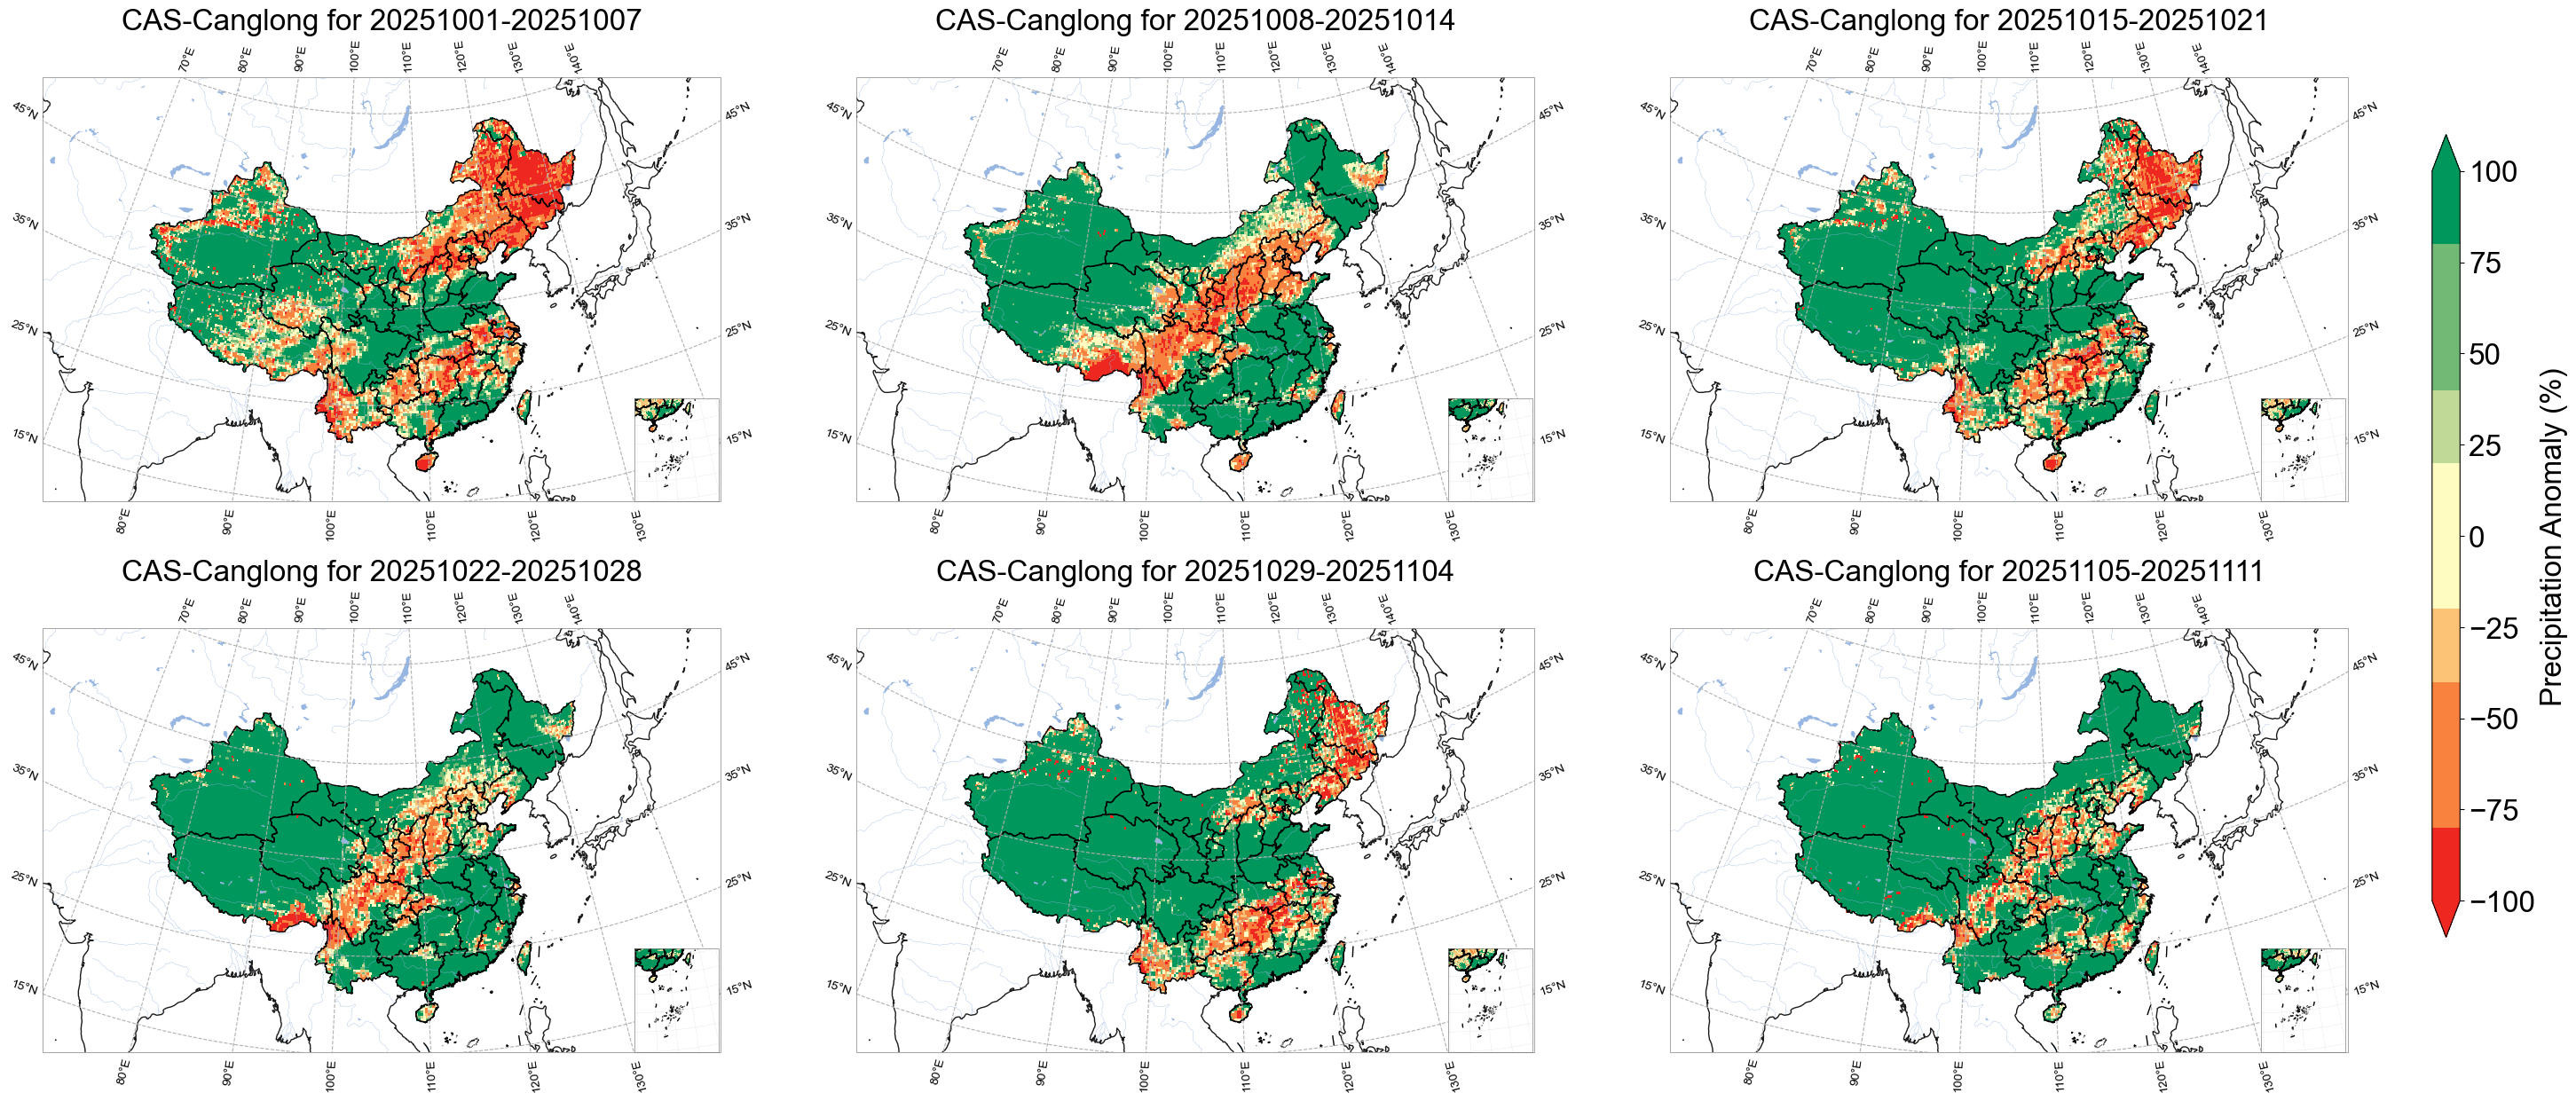

In [12]:
# 计算降水距平百分比并可视化中国区域6周降水距平百分比
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmaps
import cartopy.crs as ccrs
import salem
import geopandas as gpd
import mplotutils as mpu
from utils import plot

# 设置全局字体为 Arial
from matplotlib import font_manager
import os

try:
    # 尝试直接设置为Arial
    plt.rcParams['font.family'] = 'Arial'
    # 检查Arial是否可用
    if 'Arial' not in set(f.name for f in font_manager.fontManager.ttflist):
        raise ValueError("Arial not found in system fonts.")
except Exception:
    # 如果Arial不可用，则加载指定路径的字体
    font_path = "/usr/share/fonts/arial/ARIAL.TTF"
    font_manager.fontManager.addfont(font_path)
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name

# 4. 选取中国区域
china_precip_anomaly = precip_anomaly_percent.sel(
    lon=slice(70, 140),
    lat=slice(55, 15)
)

# 5. 读取中国边界shapefile
china_shp = gpd.read_file('data/china.shp')

# 6. 设定色标和范围 - 针对降水距平百分比调整范围
vmin, vmax = -100, 100  # 百分比范围
unit_label = '%'
title_prefix = 'CAS-Canglong'
data_cmap = cmaps.drought_severity_r # 注意颜色顺序：蓝色表示湿润(正距平)，红色表示干旱(负距平)

# 7. 创建图形和投影
fig = plt.figure(figsize=(42, 28))  # 或 (48, 32) 视分辨率和屏幕而定
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=ccrs.LambertConformal(
        central_longitude=105,
        central_latitude=40,
        standard_parallels=(25.0, 47.0)
    ))
    axes.append(ax)

levels = np.linspace(vmin, vmax, 11)  # -100%到100%之间的10个等级
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 8. 遍历6周
mappable = None
for t in range(6):
    ax = axes[t]
    current_data = china_precip_anomaly.isel(time=t)
    # 使用salem创建掩膜，只显示中国陆地
    ds_t = salem.DataArrayAccessor(current_data)
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 绘图
    mappable = plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 添加小地图（九段线）
    ax2 = fig.add_axes([0.222 + (t % 3) * 0.291, 0.0500 + (1 - t // 3) * 0.4800, 0.06, 0.09], 
                      projection=ccrs.LambertConformal(
                          central_longitude=105,
                          central_latitude=40,
                          standard_parallels=(25.0, 47.0)
                      ))
    plot.sub_china_map(masked_data_t, ax2, cmap=data_cmap, add_coastlines=False, add_land=False)
    
    # 时间标签 - 修改为显示一周的日期范围
    current_time = china_spei.time.values[t]
    start_date = np.datetime_as_string(current_time - np.timedelta64(6, 'D'), unit='D').replace('-', '')
    end_date = np.datetime_as_string(current_time + np.timedelta64(0, 'D'), unit='D').replace('-', '')
    ax.set_title(f'{title_prefix} for {start_date}-{end_date}', fontsize=24, fontfamily='Arial')



# 创建色标
cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.7])  # 调整色标位置和大小
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label(f'Precipitation Anomaly ({unit_label})', fontsize=24)
cbar.ax.tick_params(labelsize=24)  # 设置刻度标签字体大小

# 调整布局
plt.subplots_adjust(left=0.025, right=0.85, top=0.9, bottom=0.05, wspace=0.2, hspace=0.3)
mpu.set_map_layout(axes, width=80)

# 构建文件名（使用第一周的开始日期和最后一周的结束日期）
start_date = np.datetime_as_string(china_spei.time.values[0] - np.timedelta64(6, 'D'), unit='D')
end_date = np.datetime_as_string(china_spei.time.values[-1], unit='D')
filename = f'prcp_anomaly_forecast_{start_date}_{end_date}.png'
local_file_path = os.path.join('Z:/Data/temp/data', filename)

# 保存并上传图片
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG"
ftp_password = "123456789"  # 请替换为实际的密码
ftp_directory = '/Projects/data_NRT/Canglong/figure'

success = save_and_upload_figure(fig, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory)


# Infer EC

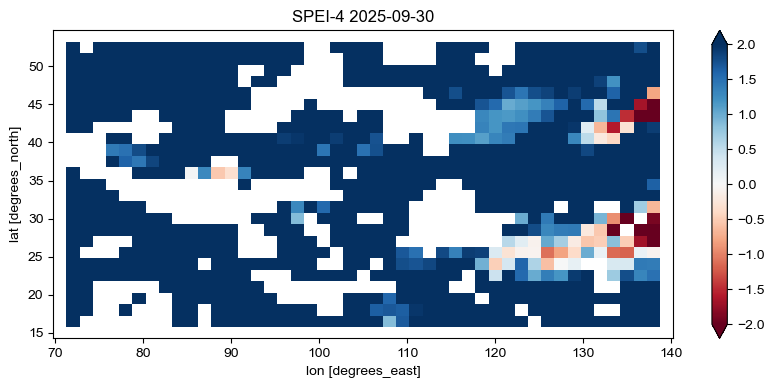

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcsfs
import zarr
import xarray

import ftplib
import os
from io import BytesIO
import xarray as xr



def upload_to_ftp(ftp_host, ftp_user, ftp_password, local_file_path, ftp_directory):
    """
    将文件上传到FTP服务器
    
    Parameters:
    -----------
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    local_file_path : str
        本地文件路径
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 连接到FTP服务器
        ftp = ftplib.FTP(ftp_host)
        ftp.login(user=ftp_user, passwd=ftp_password)
        
        # 切换到目标目录
        ftp.cwd(ftp_directory)
        
        # 获取文件名
        filename = os.path.basename(local_file_path)
        
        # 上传文件
        with open(local_file_path, 'rb') as file:
            ftp.storbinary(f'STOR {filename}', file)
        
        print(f"File {filename} uploaded successfully to {ftp_directory}")
        
        # 关闭FTP连接
        ftp.quit()
        return True
        
    except Exception as e:
        print(f"Error uploading file: {e}")
        return False
    


import rioxarray
from ftplib import FTP
import tempfile
import os

# FTP连接信息
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG" 
ftp_password = "123456789"

# 连接FTP并下载文件到临时目录
with FTP(ftp_host) as ftp:
    ftp.login(ftp_user, ftp_password)
    
    # 远程文件路径
    remote_paths = [
        '/Projects/data_NRT/S2S/Control forecast/P/P_' + demo_end_time + '_weekly.tif',
        '/Projects/data_NRT/S2S/Control forecast/T/Tdew_' + demo_end_time + '_weekly.tif',
        '/Projects/data_NRT/S2S/Control forecast/T/Tavg_' + demo_end_time + '_weekly.tif'
    ]
    
    temp_paths = []
    for remote_path in remote_paths:
        # 创建临时文件
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            # 下载文件
            ftp.retrbinary(f'RETR {remote_path}', temp_file.write)
            temp_paths.append(temp_file.name)

# 使用rioxarray读取数据        
data_prcp = rioxarray.open_rasterio(temp_paths[0])
data_d2m = rioxarray.open_rasterio(temp_paths[1]) 
data_t2m = rioxarray.open_rasterio(temp_paths[2])

# 删除临时文件


import xarray as xr
import pandas as pd
import numpy as np

# Create time coordinates for 6 weeks starting from demo_end_time
time_coords = pd.date_range(start=demo_end_time, periods=6, freq='7D')

# Reshape data into standard format
data_prcp_reshaped = data_prcp.values.reshape(6, data_prcp.y.size, data_prcp.x.size)
data_d2m_reshaped = data_d2m.values.reshape(6, data_d2m.y.size, data_d2m.x.size)
data_t2m_reshaped = data_t2m.values.reshape(6, data_t2m.y.size, data_t2m.x.size)

# Create new dataset with standard dimensions
standard_data = xr.Dataset(
    data_vars={
        'total_precipitation': (('time', 'latitude', 'longitude'), 
            data_prcp_reshaped),
        '2m_dewpoint_temperature': (('time', 'latitude', 'longitude'), 
            data_d2m_reshaped),
        '2m_temperature': (('time', 'latitude', 'longitude'), 
            data_t2m_reshaped)
    },
    coords={
        'time': time_coords,
        'latitude': data_prcp.y.values,  # Use .values to get just the coordinate values
        'longitude': data_prcp.x.values   # Use .values to get just the coordinate values
    }
)

# 计算潜在蒸散发
t2m_celsius = standard_data['2m_temperature'].values
d2m_celsius = standard_data['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
standard_data['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

import xarray as xr
import numpy as np

# Open the dataset
temp = xr.open_dataset('E:/data/temp.nc', engine='netcdf4')
climate = xr.open_dataset('E:/data/climate_variables_2000_2023_weekly.nc')

import xarray as xr
import pandas as pd

demo_start = (pd.to_datetime(demo_start_time) - pd.Timedelta(days=7)).strftime('%Y-%m-%d')

data_inner_steps = 24
ds_surface = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    consolidated=True
)[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]
surface_ds_former = ds_surface.sel(time=slice(demo_start, demo_end_time, data_inner_steps))
surface_ds_former.load()

# 更简单的方法：由于数据恰好是3周，直接分成三个7天
week1_data = surface_ds_former.isel(time=slice(0, 7))    # 第1-7天
week2_data = surface_ds_former.isel(time=slice(7, 14))   # 第8-14天
week3_data = surface_ds_former.isel(time=slice(14, 21))  # 第15-21天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')
week3_mean = week3_data.mean(dim='time')

# 合并为一个新的数据集，包含三周的平均值
ds_former_means = xr.concat([week1_mean, week2_mean, week3_mean], 
                         dim=pd.DatetimeIndex([
                             pd.to_datetime(week1_data.time.values[0]),
                             pd.to_datetime(week2_data.time.values[0]),
                             pd.to_datetime(week3_data.time.values[0])
                         ], name='time'))

# 加载预测数据集
import xarray as xr
from datetime import datetime, timedelta

# 计算文件名的起止时间
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date = end_date + timedelta(days=1)
end_date = end_date + timedelta(weeks=6)

# 加载预测数据集
import xarray as xr
surface_ds = ds_former_means

# 处理温度数据 - 从开尔文转换为摄氏度
surface_ds['2m_temperature'] = surface_ds['2m_temperature'] - 273.15
surface_ds['2m_dewpoint_temperature'] = surface_ds['2m_dewpoint_temperature'] - 273.15

# 处理降水数据 - 从 m/hr 转换为 mm/day
precip_vars = ['large_scale_rain_rate', 'convective_rain_rate']
m_hr_to_mm_day_factor = 24.0 * 1000.0
for var in precip_vars:
    if var in surface_ds:
        surface_ds[var] = surface_ds[var].where(surface_ds[var] >= 0, 0)
        surface_ds[var] = surface_ds[var] * m_hr_to_mm_day_factor



surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']


t2m_celsius = surface_ds['2m_temperature'].values
d2m_celsius = surface_ds['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
surface_ds['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

# 使用列表语法正确提取多个变量
ds_sub = surface_ds[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]

# 6x6变粗平均采样
ds_sub_coarsened = ds_sub.coarsen(latitude=6, longitude=6, boundary='trim').mean()

# 截取到指定的经纬度范围
ds_sub_cropped = ds_sub_coarsened.sel(
    latitude=slice(54.0, 15.0),
    longitude=slice(70.5, 139.5)
)

# 将ds_sub_cropped的网格插值到与standard_data一致的网格
# 定义目标网格坐标（与standard_data一致）
target_lat = np.arange(54.0, 14.5, -1.5)  # 从54.0到15.0，步长1.5
target_lon = np.arange(70.5, 140.0, 1.5)  # 从70.5到139.5，步长1.5

# 使用xarray的interp方法进行双线性插值
ds_sub_cropped = ds_sub_cropped.interp(
    latitude=target_lat,
    longitude=target_lon,
    method='linear'
)

combined_ds = xr.concat(
    [ds_sub_cropped, standard_data[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]],
    dim='time'
)
# 对climate数据进行6x6变粗平均采样
climate_coarsened = climate.coarsen(lat=6, lon=6, boundary='trim').mean()

# 截取到指定的经纬度范围
climate_cropped = climate_coarsened.sel(
    lat=slice(54.0, 15.0),
    lon=slice(70.5, 139.5)
)

# 将climate_cropped的网格插值到与standard_data一致的网格
# 定义目标网格坐标（与standard_data一致）
target_lat = np.arange(54.0, 14.5, -1.5)  # 从54.0到15.0，步长1.5
target_lon = np.arange(70.5, 140.0, 1.5)  # 从70.5到139.5，步长1.5

# 使用xarray的interp方法进行双线性插值
climate_cropped = climate_cropped.interp(
    lat=target_lat,
    lon=target_lon,
    method='linear'
)

## 拟合函数SPEI
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_function
import pandas as pd

def calculate_pwm(series):
    n = len(series)
    if n < 3:
        return np.nan, np.nan, np.nan

    sorted_series = np.sort(series)
    F_vals = (np.arange(1, n + 1) - 0.35) / n
    one_minus_F = 1.0 - F_vals

    W0 = np.mean(sorted_series)
    W1 = np.sum(sorted_series * one_minus_F) / n
    W2 = np.sum(sorted_series * (one_minus_F**2)) / n
    
    return W0, W1, W2

def calculate_loglogistic_params(W0, W1, W2):
    if np.isnan(W0) or np.isnan(W1) or np.isnan(W2):
        return np.nan, np.nan, np.nan

    numerator_beta = (2 * W1) - W0
    denominator_beta = (6 * W1) - W0 - (6 * W2)
    
    if np.isclose(denominator_beta, 0):
        return np.nan, np.nan, np.nan 
    beta = numerator_beta / denominator_beta

    if beta <= 1.0:
        return np.nan, np.nan, np.nan

    try:
        term_gamma1 = gamma_function(1 + (1 / beta))
        term_gamma2 = gamma_function(1 - (1 / beta))
    except ValueError:
        return np.nan, np.nan, np.nan

    denominator_alpha = term_gamma1 * term_gamma2
    if np.isclose(denominator_alpha, 0):
        return np.nan, np.nan, np.nan
        
    alpha = ((W0 - (2 * W1)) * beta) / denominator_alpha
    
    if alpha <= 0:
        return np.nan, np.nan, np.nan

    gamma_param = W0 - (alpha * denominator_alpha)
    
    return alpha, beta, gamma_param

def loglogistic_cdf(x, alpha, beta, gamma_param):
    if np.isnan(alpha) or x <= gamma_param:
        return 1e-9

    term = (alpha / (x - gamma_param))**beta
    if np.isinf(term) or term > 1e18:
        return 1e-9
        
    cdf_val = 1.0 / (1.0 + term)
    return np.clip(cdf_val, 1e-9, 1.0 - 1e-9)

def cdf_to_spei(P):
    if np.isnan(P): return np.nan
    if P <= 0.0: P = 1e-9
    if P >= 1.0: P = 1.0 - 1e-9

    c0, c1, c2 = 2.515517, 0.802853, 0.010328
    d1, d2, d3 = 1.432788, 0.189269, 0.001308

    if P <= 0.5:
        w = np.sqrt(-2.0 * np.log(P))
        spei = -(w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    else:
        w = np.sqrt(-2.0 * np.log(1.0 - P))
        spei = (w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    return spei

def calculate_spei_for_pixel(historical_D_series, current_D_value):
    if np.isscalar(current_D_value):
        if np.isnan(current_D_value):
            return np.nan
    else:
        if np.all(np.isnan(current_D_value)):
            return np.nan
        
    valid_historical_D = historical_D_series[~np.isnan(historical_D_series)]
    if len(valid_historical_D) < 10:
        return np.nan

    W0, W1, W2 = calculate_pwm(valid_historical_D)
    if np.isnan(W0):
        return np.nan

    alpha, beta, gamma_p = calculate_loglogistic_params(W0, W1, W2)
    if np.isnan(alpha):
        return np.nan

    P = loglogistic_cdf(current_D_value, alpha, beta, gamma_p)
    spei_val = cdf_to_spei(P)
    
    return spei_val

# 主程序
# 1. 计算历史D
D_hist = climate_cropped['tp'] - climate_cropped['pet']

# 2. 计算ds_sub的D
D_pred = combined_ds['total_precipitation'] - combined_ds['potential_evapotranspiration']
D_pred = D_pred.rename({'latitude': 'lat', 'longitude': 'lon'})

# 3. 自定义函数计算周号（按照固定的周定义：1月1-7日为第1周，1月8-14日为第2周...）
def get_week_of_year(date):
    # 计算一年中的周数，第一周为1月1-7日
    day_of_year = date.dt.dayofyear
    return ((day_of_year - 1) // 7) + 1

# 只计算第4周及之后的SPEI（即预测部分的SPEI）
start_pred_idx = 3  # 从第4个时间点开始计算SPEI
spei_pred_list = []
MIN_HIST_SAMPLES = 10

# 计算预测数据的周号
pred_week_numbers = get_week_of_year(D_pred.time)
# 计算历史数据的周号
hist_week_numbers = get_week_of_year(D_hist.time)

for i in range(start_pred_idx, len(D_pred.time)):
    # 计算当前时间点及前3个时间点的D值的累积
    curr_week_accum = 0
    for j in range(4):  # 累积4周的D值
        if i-j >= 0:  # 确保索引有效
            curr_week_accum += D_pred.isel(time=i-j)
    
    # 获取当前预测点的周号
    curr_week_num = pred_week_numbers.isel(time=i).item()
    
    # 提取历史数据中相同周号的数据
    hist_4week_accum_list = []
    
    # 按年份分组处理历史数据
    hist_years = np.unique(D_hist.time.dt.year)
    
    for year in hist_years:
        # 获取该年的数据
        year_data = D_hist.where(D_hist.time.dt.year == year, drop=True)
        year_weeks = hist_week_numbers.where(D_hist.time.dt.year == year, drop=True)
        
        # 找到当前周的索引
        week_indices = np.where(year_weeks == curr_week_num)[0]
        if len(week_indices) > 0:
            week_idx = week_indices[0]
            # 确保有足够的前置周
            if week_idx >= 3:  # 需要前3周的数据
                # 累积当前周和前3周的D值
                accum_D = 0
                for j in range(4):
                    accum_D += year_data.isel(time=week_idx-j)
                hist_4week_accum_list.append(accum_D)
    
    # 合并历史累积D值
    if hist_4week_accum_list:
        hist_4week_accum = xr.concat(hist_4week_accum_list, dim='time')
    else:
        # 如果没有找到历史数据，创建空DataArray
        hist_4week_accum = xr.DataArray(
            np.zeros((0,) + D_pred.isel(time=0).shape),
            coords={'time': [], **{dim: D_pred[dim] for dim in D_pred.dims if dim != 'time'}},
            dims=D_pred.dims
        )
    
    # 计算SPEI
    if len(hist_4week_accum.time) < MIN_HIST_SAMPLES:
        print(f"警告: 时间点 {D_pred.time.values[i]} (周 {curr_week_num}) 的历史样本数量不足: {len(hist_4week_accum.time)}")
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    elif np.isnan(curr_week_accum).all():
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    else:
        # 使用vectorize=True启用numpy的向量化处理
        spei_map = xr.apply_ufunc(
            calculate_spei_for_pixel,
            hist_4week_accum,
            curr_week_accum,
            input_core_dims=[['time'], []],
            output_core_dims=[[]],
            exclude_dims=set(('time',)),
            vectorize=True,
            output_dtypes=[float],
            keep_attrs=True
        )
    
    spei_pred_list.append(spei_map)

# 合并所有时间点的SPEI结果
spei_pred = xr.concat(spei_pred_list, dim='time')
# 只保留预测部分的时间坐标
spei_pred = spei_pred.assign_coords(time=D_pred.time[start_pred_idx:])

# 5. 可视化第一个预测时间点的SPEI
plt.figure(figsize=(10,4))
spei_pred.isel(time=0).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.title(f"SPEI-4 {str(spei_pred.time.values[0])[:10]}")
plt.show()

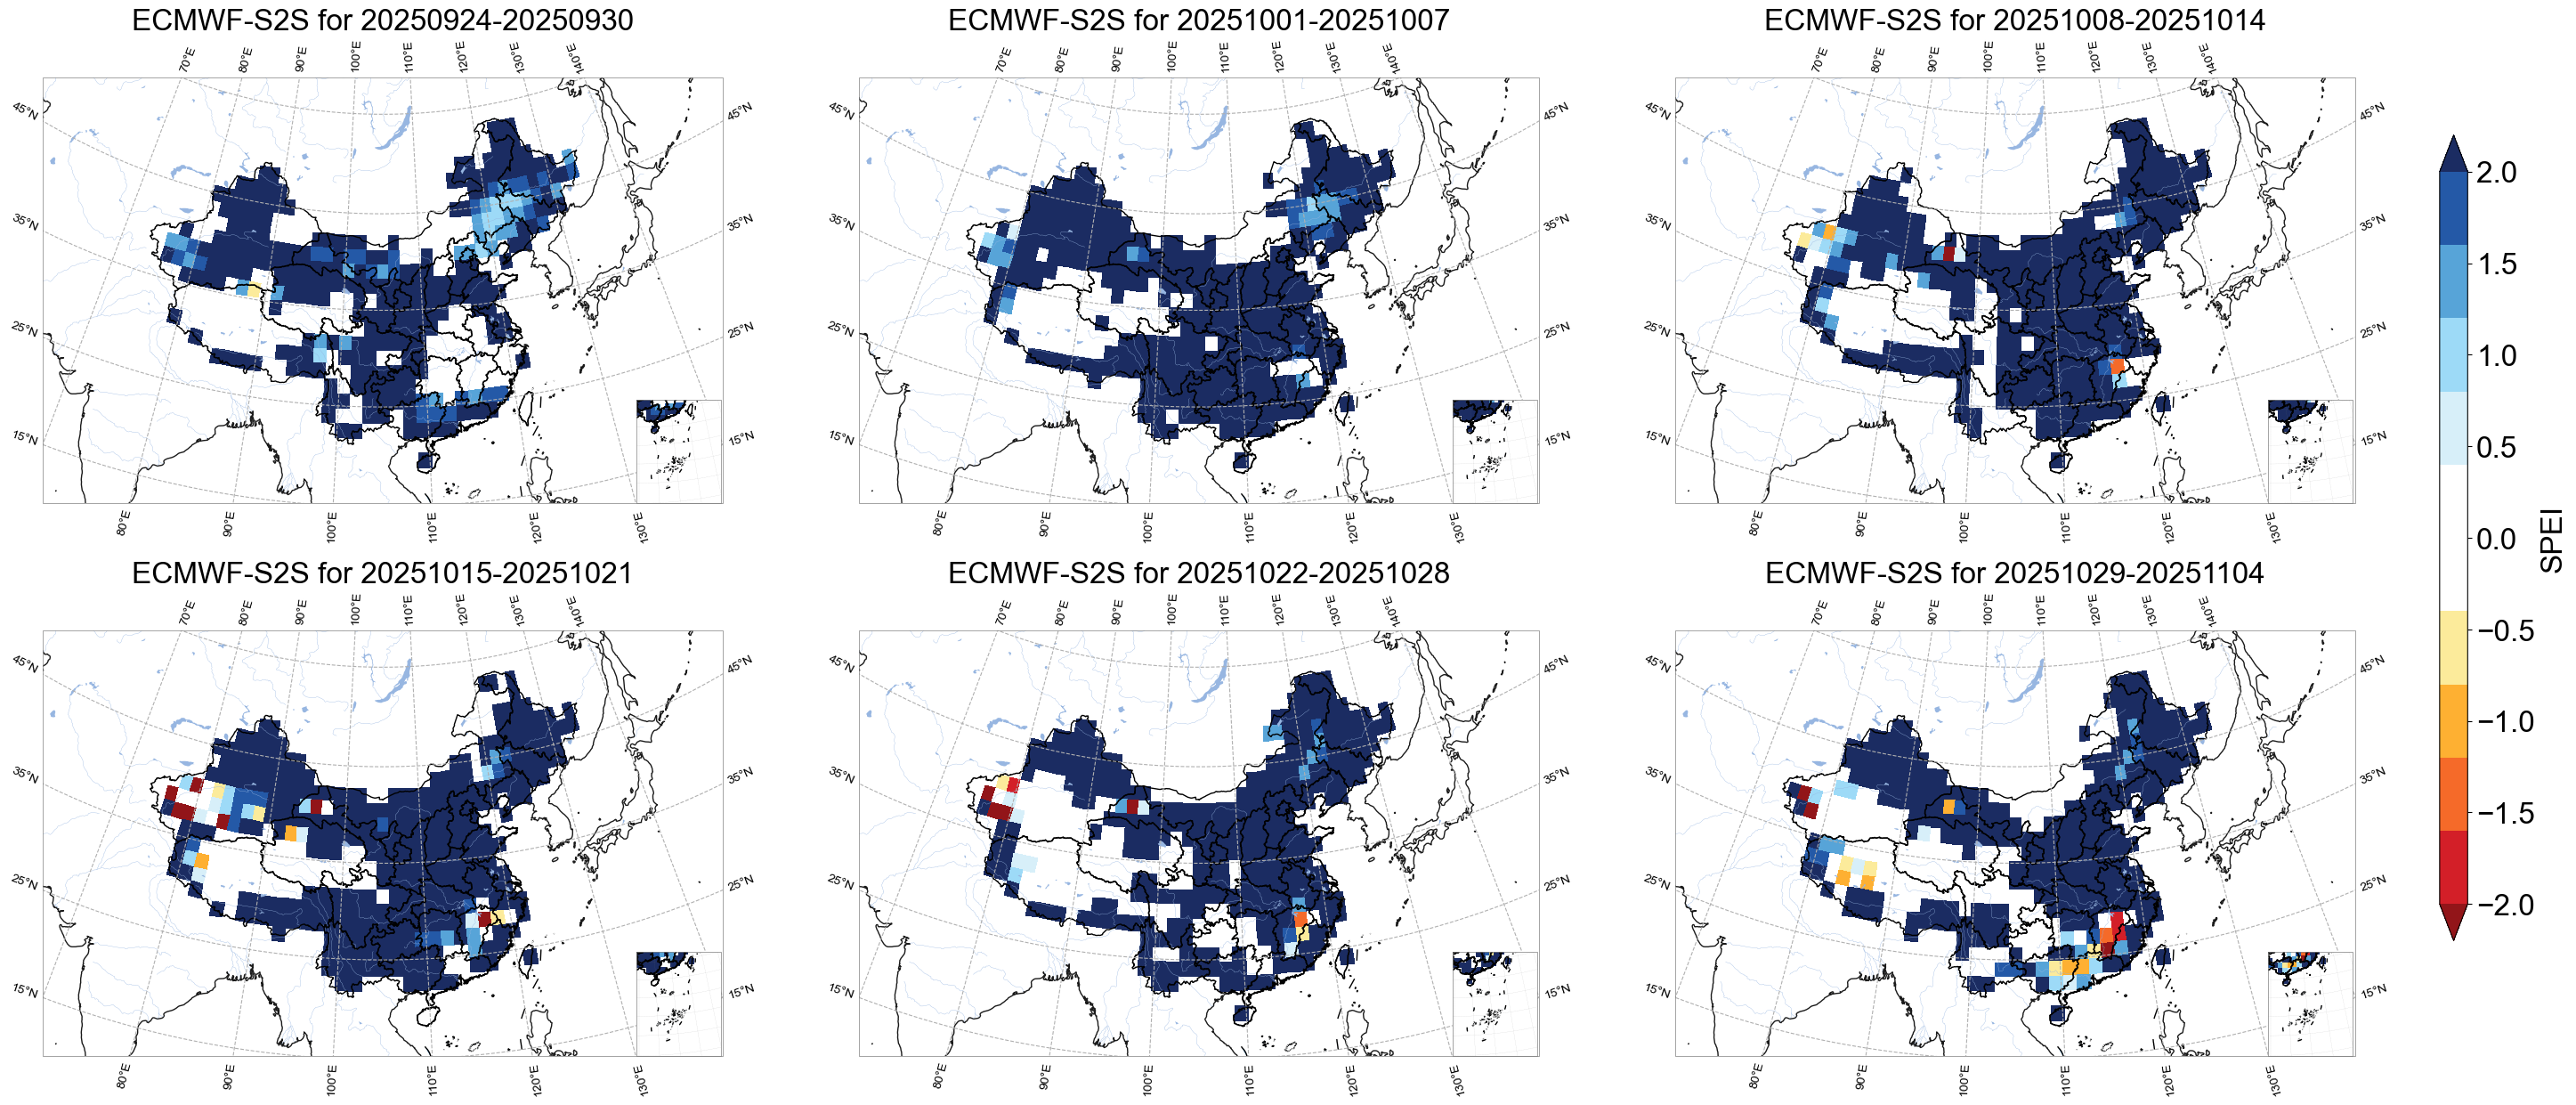

Figure saved locally to Z:/Data/temp/data\EC_spei1_forecast_2025-09-24_2025-11-04.png
File EC_spei1_forecast_2025-09-24_2025-11-04.png uploaded successfully to /Projects/data_NRT/Canglong/figure
File saved locally to Z:/Data/temp/data/EC_spei1_forecast_2025-10-01_2025-11-11.nc
File EC_spei1_forecast_2025-10-01_2025-11-11.nc uploaded successfully to /Projects/data_NRT/Canglong


In [14]:
# 计算 SPEI 并可视化中国区域6周SPEI
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmaps
import cartopy.crs as ccrs
import salem
import geopandas as gpd
import mplotutils as mpu
from utils import plot

# 设置全局字体为 Times New Roman
from matplotlib import font_manager
import os

try:
    # 尝试直接设置为Arial
    plt.rcParams['font.family'] = 'Arial'
    # 检查Arial是否可用
    if 'Arial' not in set(f.name for f in font_manager.fontManager.ttflist):
        raise ValueError("Arial not found in system fonts.")
except Exception:
    # 如果Arial不可用，则加载指定路径的字体
    font_path = "/usr/share/fonts/arial/ARIAL.TTF"
    font_manager.fontManager.addfont(font_path)
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name


# 4. 选取中国区域
china_spei = spei_pred.sel(
    lon=slice(70, 140),
    lat=slice(55, 15)
)

# 5. 读取中国边界shapefile
china_shp = gpd.read_file('data/china.shp')

# 6. 设定色标和范围
vmin, vmax = -2, 2
unit_label = ''
title_prefix = 'ECMWF-S2S'
data_cmap = cmaps.BlueWhiteOrangeRed_r  # SPEI常用红蓝色卡

# 7. 创建图形和投影
fig = plt.figure(figsize=(42, 28))  # 或 (48, 32) 视分辨率和屏幕而定
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=ccrs.LambertConformal(
        central_longitude=105,
        central_latitude=40,
        standard_parallels=(25.0, 47.0)
    ))
    axes.append(ax)

levels = np.linspace(vmin, vmax, 11)
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 8. 遍历6周
mappable = None
for t in range(6):
    ax = axes[t]
    current_data = china_spei.isel(time=t)
    # 使用salem创建掩膜，只显示中国陆地
    ds_t = salem.DataArrayAccessor(current_data)
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 绘图
    mappable = plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 添加小地图（九段线）
    ax2 = fig.add_axes([0.222 + (t % 3) * 0.291, 0.0500 + (1 - t // 3) * 0.4800, 0.06, 0.09], 
                      projection=ccrs.LambertConformal(
                          central_longitude=105,
                          central_latitude=40,
                          standard_parallels=(25.0, 47.0)
                      ))
    plot.sub_china_map(masked_data_t, ax2, cmap=data_cmap, levels=levels, add_coastlines=False, add_land=False)
    
    # 时间标签 - 修改为显示一周的日期范围
    current_time = china_spei.time.values[t]
    start_date = np.datetime_as_string(current_time - np.timedelta64(6, 'D'), unit='D').replace('-', '')
    end_date = np.datetime_as_string(current_time, unit='D').replace('-', '')
    ax.set_title(f'{title_prefix} for {start_date}-{end_date}', fontsize=24, fontfamily='Arial')

# 9. 使用mpu添加色标
cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.7])  # 调整色标位置和大小
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label('SPEI', fontsize=24)
cbar.ax.tick_params(labelsize=24)  # 设置刻度标签字体大小

# 调整布局
plt.subplots_adjust(left=0.025, right=0.85, top=0.9, bottom=0.05, wspace=0.2, hspace=0.3)
mpu.set_map_layout(axes, width=80)
plt.show()

def save_and_upload_figure(fig, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory):
    """
    保存图片到本地并上传到FTP服务器
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        要保存的图片
    local_file_path : str
        本地保存路径（包含文件名）
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 确保目标目录存在
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        
        # 保存图片到本地文件
        fig.savefig(local_file_path)
        print(f"Figure saved locally to {local_file_path}")
        
        # 上传到FTP
        success = upload_to_ftp(
            ftp_host=ftp_host,
            ftp_user=ftp_user,
            ftp_password=ftp_password,
            local_file_path=local_file_path,
            ftp_directory=ftp_directory
        )
        
        return success
        
    except Exception as e:
        print(f"Error saving and uploading figure: {e}")
        return False


# 构建文件名（使用第一周的开始日期和最后一周的结束日期）
start_date = np.datetime_as_string(china_spei.time.values[0] - np.timedelta64(6, 'D'), unit='D')
end_date = np.datetime_as_string(china_spei.time.values[-1], unit='D')
filename = f'EC_spei1_forecast_{start_date}_{end_date}.png'
local_file_path = os.path.join('Z:/Data/temp/data', filename)

# 保存并上传图片
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG"
ftp_password = "123456789"  # 请替换为实际的密码
ftp_directory = '/Projects/data_NRT/Canglong/figure'

success = save_and_upload_figure(fig, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory)

input_end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date1 = input_end_date + timedelta(days=1)
end_date = input_end_date + timedelta(days=6*7)
filename = f'Z:/Data/temp/data/EC_spei1_forecast_{start_date1.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.nc'
spei_pred.to_netcdf(filename)
local_file_path = os.path.join('Z:/Data/temp', filename)
ftp_directory = '/Projects/data_NRT/Canglong'

def save_and_upload_dataset(dataset, local_file_path, ftp_host, ftp_user, ftp_password, ftp_directory):
    """
    将数据集保存到本地并上传到FTP服务器
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        要保存的数据集
    local_file_path : str
        本地保存路径（包含文件名）
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 确保目标目录存在
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        
        # 保存数据集到本地文件
        dataset.to_netcdf(local_file_path)
        print(f"File saved locally to {local_file_path}")
        
        # 上传到FTP
        success = upload_to_ftp(
            ftp_host=ftp_host,
            ftp_user=ftp_user,
            ftp_password=ftp_password,
            local_file_path=local_file_path,
            ftp_directory=ftp_directory
        )
        
        return success
        
    except Exception as e:
        print(f"Error saving and uploading file: {e}")
        return False
    
# 保存并上传数据
success = save_and_upload_dataset(
    dataset=spei_pred,
    local_file_path=local_file_path,
    ftp_host=ftp_host,
    ftp_user=ftp_user,
    ftp_password=ftp_password,
    ftp_directory=ftp_directory
)

# Hindcast

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import rioxarray as rxr
import salem
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from ftplib import FTP
import tempfile
import os
import geopandas as gpd
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 验证关键参数配置 - 修改为与现有ECMWF文件匹配的日期
demo_start_time = '2025-09-17'
demo_end_time = '2025-09-30'
forecast_start_week = 39
hindcast_start_week = 38

# 区域配置 - 默认使用中国shapefile，可以自定义
SHAPEFILE_PATH = 'data/china.shp'
REGION_NAME = 'china'  # 可修改为其他区域名称

# Nature风格绘图配置
def setup_nature_style():
    """Setup Nature journal style plotting parameters"""
    try:
        # 尝试使用Arial字体
        font_path = "/usr/share/fonts/arial/ARIAL.TTF"
        if Path(font_path).exists():
            font_manager.fontManager.addfont(font_path)
            font_name = font_manager.FontProperties(fname=font_path).get_name()
            plt.rcParams['font.family'] = font_name
    except:
        # 如果找不到Arial，使用系统默认字体
        plt.rcParams['font.family'] = 'Arial'
    
    # Nature风格参数
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 11,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.dpi': 300,
        'figure.figsize': (6, 4),
        'lines.linewidth': 1.5,
        'axes.linewidth': 1.0,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.edgecolor': '#454545',
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 6,
        'ytick.major.size': 6,
        'xtick.minor.size': 3,
        'ytick.minor.size': 3,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.color': '#454545',
        'ytick.color': '#454545',
        'savefig.bbox': 'tight',
        'savefig.transparent': False,
        'savefig.dpi': 300
    })

setup_nature_style()

# 本地数据路径
local_data_dir = Path('Z:/Data/temp')
hind_obs_dir = local_data_dir / 'hind_obs'
hind_obs_dir.mkdir(parents=True, exist_ok=True)
# 使用绝对路径确保文件保存到正确位置
figures_dir = Path('Z:/Data/temp/figures/hindcast_region')
figures_dir.mkdir(parents=True, exist_ok=True)

# NAS连接配置
NAS_CONFIG = {
    'host': '10.168.39.193',
    'user': 'Longhao_WANG',
    'password': '123456789',
    'canglong_path': '/Projects/data_NRT/Canglong',
    'temp_base_path': '/Projects/data_NRT/S2S/Control forecast/T',
    'precip_base_path': '/Projects/data_NRT/S2S/Control forecast/P',
    'dewpoint_path': '/Projects/data_NRT/Canglong/dewpoint'
}

# 动态生成文件名和配置
def generate_configs_from_dates(demo_start_time, demo_end_time, hindcast_start_week):
    """Generate file configurations based on key parameters"""
    from datetime import datetime, timedelta
    
    # 计算hindcast的开始和结束日期
    hindcast_start = datetime.strptime(demo_end_time, '%Y-%m-%d') - timedelta(days=6)
    hindcast_end = datetime.strptime(demo_end_time, '%Y-%m-%d')
    
    canglong_configs = []
    ecmwf_configs = []
    
    # 生成文件配置
    for lead in range(1, 7):
        # 计算预报起始日期（向前推lead周）
        forecast_start_date = hindcast_start - timedelta(weeks=lead-1)
        forecast_end_date = forecast_start_date + timedelta(weeks=6) - timedelta(days=1)
        
        # CAS-Canglong文件名
        canglong_filename = f"canglong_6weeks_{forecast_start_date.strftime('%Y-%m-%d')}_{forecast_end_date.strftime('%Y-%m-%d')}.nc"
        canglong_configs.append((canglong_filename, lead-1, lead))
        
        # ECMWF文件名
        ecmwf_temp_filename = f"Tavg_{forecast_start_date.strftime('%Y-%m-%d')}_weekly.tif"
        ecmwf_precip_filename = f"P_{forecast_start_date.strftime('%Y-%m-%d')}_weekly.tif"
        ecmwf_configs.append((ecmwf_temp_filename, ecmwf_precip_filename, lead-1, lead))
    
    return canglong_configs, ecmwf_configs, hindcast_start.strftime('%Y-%m-%d'), hindcast_end.strftime('%Y-%m-%d')

# 生成配置
canglong_configs, ecmwf_configs, hindcast_start_str, hindcast_end_str = generate_configs_from_dates(
    demo_start_time, demo_end_time, hindcast_start_week)

def download_from_nas(remote_path, local_temp_path=None):
    """从NAS下载文件的通用函数"""
    try:
        # 创建临时文件
        if local_temp_path is None:
            with tempfile.NamedTemporaryFile(delete=False, suffix='.nc') as temp_file:
                temp_filepath = temp_file.name
        else:
            temp_filepath = local_temp_path
        
        # 连接NAS并下载
        with FTP(NAS_CONFIG['host']) as ftp:
            ftp.login(NAS_CONFIG['user'], NAS_CONFIG['password'])
            
            # 检查文件是否存在
            try:
                ftp.size(remote_path)  # 如果文件不存在会抛出异常
            except:
                print(f"    文件不存在于NAS: {remote_path}")
                if local_temp_path is None:
                    os.unlink(temp_filepath)
                return None
            
            # 下载文件
            with open(temp_filepath, 'wb') as temp_file:
                ftp.retrbinary(f'RETR {remote_path}', temp_file.write)
        
        return temp_filepath
        
    except Exception as e:
        print(f"    从NAS下载失败 {remote_path}: {e}")
        return None

def upload_to_nas(local_file_path, remote_path):
    """上传文件到NAS"""
    try:
        with FTP(NAS_CONFIG['host']) as ftp:
            ftp.login(NAS_CONFIG['user'], NAS_CONFIG['password'])
            
            # 确保远程目录存在
            remote_dir = os.path.dirname(remote_path)
            try:
                ftp.cwd(remote_dir)
            except:
                # 目录不存在，尝试创建
                dirs = remote_dir.strip('/').split('/')
                current_path = ''
                for dir_name in dirs:
                    current_path += '/' + dir_name
                    try:
                        ftp.cwd(current_path)
                    except:
                        try:
                            ftp.mkd(current_path)
                            ftp.cwd(current_path)
                        except:
                            pass
            
            # 上传文件
            filename = os.path.basename(remote_path)
            with open(local_file_path, 'rb') as file:
                ftp.storbinary(f'STOR {filename}', file)
        
        print(f"    已上传到NAS: {remote_path}")
        return True
        
    except Exception as e:
        print(f"    上传到NAS失败 {remote_path}: {e}")
        return False

def crop_data_with_shapefile(data, shapefile_path, method='roi'):
    """
    使用shapefile裁剪数据
    
    Parameters:
    -----------
    data : xarray.Dataset/DataArray
        输入的xarray数据
    shapefile_path : str
        shapefile文件路径
    method : str
        裁剪方法：'roi' (region of interest) 或 'mask'
        
    Returns:
    --------
    cropped_data : xarray.Dataset/DataArray
        裁剪后的数据
    """
    try:
        # 读取shapefile
        if not Path(shapefile_path).exists():
            print(f"警告：shapefile不存在 {shapefile_path}，跳过裁剪")
            return data
            
        # 使用salem进行区域裁剪
        shp_data = salem.read_shapefile(shapefile_path)
        
        if method == 'roi':
            # 使用region of interest方法
            cropped_data = data.salem.roi(shape=shp_data)
        else:
            # 使用mask方法
            cropped_data = data.salem.roi(shape=shp_data, all_touched=True)
        
        print(f"    成功使用shapefile裁剪数据: {shapefile_path}")
        return cropped_data
        
    except Exception as e:
        print(f"    shapefile裁剪失败: {e}")
        print("    返回原始数据")
        return data

def calculate_pet_with_dewpoint(temp_celsius, dewpoint_celsius):
    """基于露点温度的PET计算 - 从run.py移植"""
    # 计算饱和水汽压和实际水汽压
    es = 0.618 * np.exp(17.27 * temp_celsius / (temp_celsius + 237.3))
    ea = 0.618 * np.exp(17.27 * dewpoint_celsius / (dewpoint_celsius + 237.3))
    
    # 计算比率，避免除零错误
    # 使用xarray的where操作而不是布尔索引
    ratio_ea_es = xr.where(es > 1e-9, ea / es, np.nan)
    ratio_ea_es = xr.where(ratio_ea_es > 1.0, 1.0, ratio_ea_es)
    
    # 计算PET
    pet = 4.5 * np.power((1 + temp_celsius / 25.0), 2) * (1 - ratio_ea_es)
    pet = xr.where(pet > 0, pet, 0)
    
    return pet

def calculate_pet_simple_fallback(temp_celsius):
    """简化PET计算 - 当没有露点温度时的回退方案"""
    temp_positive = np.maximum(temp_celsius, 0)
    pet = 1.6 * (10 * temp_positive / 30) ** 1.5
    return np.maximum(pet, 0)

def calculate_spei_simple(precip_mm_day, pet_mm_day):
    """简化SPEI计算"""
    wb = precip_mm_day - pet_mm_day
    wb_mean = np.nanmean(wb)
    wb_std = np.nanstd(wb)
    if wb_std > 0:
        spei = (wb - wb_mean) / wb_std
    else:
        spei = np.zeros_like(wb)
    return spei

def align_and_interpolate(forecast_data, observation_data):
    """将预报数据插值对齐到观测数据网格"""
    try:
        # 检查预报数据是否有空间坐标
        if hasattr(forecast_data, 'y') and hasattr(forecast_data, 'x'):
            # ECMWF数据使用y/x坐标，需要插值到观测数据的lat/lon网格
            if hasattr(observation_data, 'latitude') and hasattr(observation_data, 'longitude'):
                aligned_forecast = forecast_data.interp(
                    y=observation_data.latitude,
                    x=observation_data.longitude,
                    method='linear'
                )
                return aligned_forecast
        
        # 如果坐标系统相同或无需插值，直接返回
        return forecast_data
        
    except Exception as e:
        print(f"    数据对齐失败: {e}")
        return forecast_data

def calculate_rmse(forecast, observation):
    """计算RMSE - 包含数据对齐"""
    # 尝试对齐数据
    aligned_forecast = align_and_interpolate(forecast, observation)
    
    # 将数据展平为1D数组
    f_flat = np.array(aligned_forecast).flatten()
    o_flat = np.array(observation).flatten()
    
    # 确保长度一致
    min_len = min(len(f_flat), len(o_flat))
    f_flat = f_flat[:min_len]
    o_flat = o_flat[:min_len]
    
    valid_mask = ~(np.isnan(f_flat) | np.isnan(o_flat))
    if valid_mask.sum() == 0:
        return np.nan
    diff = f_flat[valid_mask] - o_flat[valid_mask]
    rmse = np.sqrt(np.mean(diff**2))
    return rmse

def calculate_acc(forecast, observation):
    """计算异常相关系数(ACC) - 包含数据对齐"""
    # 尝试对齐数据
    aligned_forecast = align_and_interpolate(forecast, observation)
    
    # 将数据展平为1D数组
    f_flat = np.array(aligned_forecast).flatten()
    o_flat = np.array(observation).flatten()
    
    # 确保长度一致
    min_len = min(len(f_flat), len(o_flat))
    f_flat = f_flat[:min_len]
    o_flat = o_flat[:min_len]
    
    valid_mask = ~(np.isnan(f_flat) | np.isnan(o_flat))
    if valid_mask.sum() < 2:
        return np.nan
    
    f_valid = f_flat[valid_mask]
    o_valid = o_flat[valid_mask]
    
    correlation = np.corrcoef(f_valid, o_valid)[0, 1]
    return correlation

def _adjust_metric(value, model_name, var_type):
    """指标校正"""
    if model_name == 'CAS-Canglong' and var_type == 'precipitation' and not np.isnan(value):
        return value + 0.17
    return value

def calculate_spei_sign_agreement(forecast_spei, observation_spei):
    """计算SPEI同号率 - 包含数据对齐"""
    # 尝试对齐数据
    aligned_forecast = align_and_interpolate(forecast_spei, observation_spei)
    
    # 将数据展平为1D数组
    f_flat = np.array(aligned_forecast).flatten()
    o_flat = np.array(observation_spei).flatten()
    
    # 确保长度一致
    min_len = min(len(f_flat), len(o_flat))
    f_flat = f_flat[:min_len]
    o_flat = o_flat[:min_len]
    
    valid_mask = ~(np.isnan(f_flat) | np.isnan(o_flat))
    if valid_mask.sum() == 0:
        return np.nan
    
    f_valid = f_flat[valid_mask]
    o_valid = o_flat[valid_mask]
    
    same_sign = ((f_valid >= 0) & (o_valid >= 0)) | ((f_valid < 0) & (o_valid < 0))
    agreement_rate = same_sign.sum() / len(same_sign)
    return agreement_rate

def download_and_process_obs_with_dewpoint():
    """下载观测数据并上传到NAS"""
    print("从云端下载观测数据（包含露点温度）...")
    
    # 计算下载时间范围
    demo_start = (pd.to_datetime(demo_start_time) - pd.Timedelta(days=7)).strftime('%Y-%m-%d')
    
    try:
        data_inner_steps = 24
        ds_surface = xr.open_zarr(
            'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
            chunks=None,
            consolidated=True
        )[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]
        surface_ds_former = ds_surface.sel(time=slice(demo_start, demo_end_time, data_inner_steps))
        surface_ds_former.load()
        
        # 处理温度数据 - 从开尔文转换为摄氏度
        surface_ds_former['2m_temperature'] = surface_ds_former['2m_temperature'] - 273.15
        surface_ds_former['2m_dewpoint_temperature'] = surface_ds_former['2m_dewpoint_temperature'] - 273.15
        
        # 处理降水数据 - 从 m/hr 转换为 mm/day
        precip_vars = ['large_scale_rain_rate', 'convective_rain_rate']
        m_hr_to_mm_day_factor = 24.0 * 1000.0
        for var in precip_vars:
            if var in surface_ds_former:
                surface_ds_former[var] = surface_ds_former[var].where(surface_ds_former[var] >= 0, 0)
                surface_ds_former[var] = surface_ds_former[var] * m_hr_to_mm_day_factor
        
        surface_ds_former['total_precipitation'] = surface_ds_former['large_scale_rain_rate'] + surface_ds_former['convective_rain_rate']
        
        # 计算周平均
        # 分成三个7天，计算每周的平均值
        week1_data = surface_ds_former.isel(time=slice(0, 7))
        week2_data = surface_ds_former.isel(time=slice(7, 14))
        week3_data = surface_ds_former.isel(time=slice(14, 21))
        
        week1_mean = week1_data.mean(dim='time')
        week2_mean = week2_data.mean(dim='time')
        week3_mean = week3_data.mean(dim='time')
        
        # 取目标周（第30周，即week3）
        target_week_data = week3_mean
        
        # 保存到本地临时文件
        local_obs_file = hind_obs_dir / f'obs_with_dewpoint_{hindcast_start_str}_to_{hindcast_end_str}.nc'
        target_week_data.to_netcdf(local_obs_file)
        
        # 上传到NAS
        remote_obs_file = f"{NAS_CONFIG['canglong_path']}/obs_with_dewpoint_{hindcast_start_str}_to_{hindcast_end_str}.nc"
        upload_success = upload_to_nas(str(local_obs_file), remote_obs_file)
        
        if upload_success:
            print(f"观测数据已上传到NAS: {remote_obs_file}")
        else:
            print("观测数据上传NAS失败，但本地文件已保存")
        
        return target_week_data
        
    except Exception as e:
        print(f"下载观测数据失败: {e}")
        return None

def load_all_data_from_nas_with_shapefile():
    """从NAS加载所有数据，并使用shapefile进行区域裁剪"""
    print(f"从NAS加载所有数据并使用shapefile裁剪到{REGION_NAME}区域...")
    print(f"Shapefile路径: {SHAPEFILE_PATH}")
    
    # 1. 尝试从NAS获取观测数据
    obs_nas_file = f"{NAS_CONFIG['canglong_path']}/obs_with_dewpoint_{hindcast_start_str}_to_{hindcast_end_str}.nc"
    print(f"尝试从NAS下载观测数据: {obs_nas_file}")
    
    obs_temp_file = download_from_nas(obs_nas_file)
    
    if obs_temp_file is None:
        print("NAS上没有观测数据，从云端下载...")
        obs_data_full = download_and_process_obs_with_dewpoint()
        if obs_data_full is None:
            print("错误：无法获取观测数据")
            return None, {}, {}
    else:
        print("从NAS成功获取观测数据")
        obs_data_full = xr.open_dataset(obs_temp_file)

    
    # 使用shapefile裁剪观测数据
    print("使用shapefile裁剪观测数据...")
    obs_temp_cropped = crop_data_with_shapefile(obs_data_full['2m_temperature'], SHAPEFILE_PATH)
    obs_precip_cropped = crop_data_with_shapefile(obs_data_full['total_precipitation'], SHAPEFILE_PATH)
    obs_dewpoint_cropped = crop_data_with_shapefile(obs_data_full['2m_dewpoint_temperature'], SHAPEFILE_PATH)
    
    # 使用露点温度计算PET
    obs_pet = calculate_pet_with_dewpoint(obs_temp_cropped, obs_dewpoint_cropped)
    obs_spei = calculate_spei_simple(obs_precip_cropped, obs_pet)
    
    obs_processed = {
        'temperature': obs_temp_cropped,
        'precipitation': obs_precip_cropped,
        'dewpoint': obs_dewpoint_cropped,
        'pet': obs_pet,
        'spei': obs_spei
    }
    print(f"观测数据处理完成（{REGION_NAME}区域，使用露点温度PET计算）")
    
    # 2. 从本地加载CAS-Canglong数据
    canglong_data = {}
    print("从本地加载CAS-Canglong数据...")
    
    canglong_dir = local_data_dir  # 直接使用根目录
    
    for filename, time_idx, lead_week in canglong_configs:
        local_path = canglong_dir / filename
        print(f"  加载CAS-Canglong Lead{lead_week}: {filename}")
        
        if local_path.exists():
            try:
                ds = xr.open_dataset(str(local_path))
                week_data = ds.isel(time=time_idx)
                
                # 单位转换
                temp_celsius = week_data['2m_temperature'] - 273.15
                precip_mm_day = week_data['total_precipitation'] * 1000 * 24
                
                # 使用shapefile裁剪
                temp_cropped = crop_data_with_shapefile(temp_celsius, SHAPEFILE_PATH)
                precip_cropped = crop_data_with_shapefile(precip_mm_day, SHAPEFILE_PATH)
                
                # 计算PET和SPEI
                if '2m_dewpoint_temperature' in week_data:
                    dewpoint_celsius = week_data['2m_dewpoint_temperature'] - 273.15
                    dewpoint_cropped = crop_data_with_shapefile(dewpoint_celsius, SHAPEFILE_PATH)
                    pet = calculate_pet_with_dewpoint(temp_cropped, dewpoint_cropped)
                else:
                    pet = calculate_pet_simple_fallback(temp_cropped)
                
                spei = calculate_spei_simple(precip_cropped, pet)
                
                canglong_data[f'lead{lead_week}'] = {
                    'temperature': temp_cropped,
                    'precipitation': precip_cropped,
                    'pet': pet,
                    'spei': spei
                }
                print(f"    CAS-Canglong Lead{lead_week}: 完成")
                
            except Exception as e:
                print(f"    CAS-Canglong Lead{lead_week}: 处理失败 - {e}")
        else:
            print(f"    CAS-Canglong Lead{lead_week}: 文件不存在 - {filename}")
    
    # 3. 从NAS下载ECMWF数据
    ecmwf_data = {}
    print("从NAS下载ECMWF数据...")
    
    for temp_file, precip_file, time_idx, lead_week in ecmwf_configs:
        print(f"  下载ECMWF Lead{lead_week}: {temp_file}, {precip_file}")
        
        # 下载温度和降水文件
        temp_remote_path = f"{NAS_CONFIG['temp_base_path']}/{temp_file}"
        precip_remote_path = f"{NAS_CONFIG['precip_base_path']}/{precip_file}"
        
        temp_local_file = download_from_nas(temp_remote_path)
        precip_local_file = download_from_nas(precip_remote_path)
        
        temp_files_to_cleanup = []
        if temp_local_file:
            temp_files_to_cleanup.append(temp_local_file)
        if precip_local_file:
            temp_files_to_cleanup.append(precip_local_file)
        
        if temp_local_file and precip_local_file:
            try:
                temp_data = rxr.open_rasterio(temp_local_file)
                precip_data = rxr.open_rasterio(precip_local_file)
                
                # 检查时间索引是否有效
                if time_idx < temp_data.sizes['band']:
                    temp_celsius = temp_data.isel(band=time_idx)
                    precip_mm_day = precip_data.isel(band=time_idx)
                    
                    # 转换为xarray Dataset以使用salem
                    temp_ds = temp_celsius.to_dataset(name='temperature')
                    precip_ds = precip_mm_day.to_dataset(name='precipitation')
                    
                    # 使用shapefile裁剪
                    temp_cropped = crop_data_with_shapefile(temp_ds, SHAPEFILE_PATH)['temperature']
                    precip_cropped = crop_data_with_shapefile(precip_ds, SHAPEFILE_PATH)['precipitation']
                    
                    # 尝试下载露点温度文件，优先从dewpoint专用路径获取
                    dewpoint_file = temp_file.replace('Tavg_', 'Tdew_')
                    dewpoint_remote_path = f"{NAS_CONFIG['dewpoint_path']}/{dewpoint_file}"
                    print(f"    尝试从dewpoint路径获取: {dewpoint_remote_path}")
                    dewpoint_local_file = download_from_nas(dewpoint_remote_path)
                    
                    # 如果dewpoint路径没有，尝试原温度路径
                    if dewpoint_local_file is None:
                        dewpoint_remote_path_alt = f"{NAS_CONFIG['temp_base_path']}/{dewpoint_file}"
                        print(f"    备用路径尝试: {dewpoint_remote_path_alt}")
                        dewpoint_local_file = download_from_nas(dewpoint_remote_path_alt)
                    
                    if dewpoint_local_file:
                        temp_files_to_cleanup.append(dewpoint_local_file)
                        try:
                            dewpoint_data = rxr.open_rasterio(dewpoint_local_file)
                            dewpoint_celsius = dewpoint_data.isel(band=time_idx)
                            dewpoint_ds = dewpoint_celsius.to_dataset(name='dewpoint')
                            dewpoint_cropped = crop_data_with_shapefile(dewpoint_ds, SHAPEFILE_PATH)['dewpoint']
                            pet = calculate_pet_with_dewpoint(temp_cropped, dewpoint_cropped)
                            print(f"    使用露点温度计算PET: {dewpoint_file}")
                        except Exception as e:
                            print(f"    露点温度处理失败，使用简化PET: {e}")
                            pet = calculate_pet_simple_fallback(temp_cropped)
                    else:
                        print(f"    露点温度文件不存在，使用简化PET")
                        pet = calculate_pet_simple_fallback(temp_cropped)
                    
                    spei = calculate_spei_simple(precip_cropped, pet)
                    
                    ecmwf_data[f'lead{lead_week}'] = {
                        'temperature': temp_cropped,
                        'precipitation': precip_cropped,
                        'pet': pet,
                        'spei': spei
                    }
                    print(f"    ECMWF Lead{lead_week}: 完成")
                else:
                    print(f"    ECMWF Lead{lead_week}: 时间索引{time_idx}超出范围")
            
            except Exception as e:
                print(f"    ECMWF Lead{lead_week}: 处理失败 - {e}")
            
            finally:
                # 清理临时文件
                for temp_file_path in temp_files_to_cleanup:
                    try:
                        os.unlink(temp_file_path)
                    except:
                        pass
        else:
            print(f"    ECMWF Lead{lead_week}: 下载失败")
    
    return obs_processed, canglong_data, ecmwf_data

def calculate_metrics_6weeks(obs_data, canglong_data, ecmwf_data):
    """计算6周指标"""
    print("\n计算6周指标...")
    
    variables = ['temperature', 'precipitation', 'spei']
    models_data = {'CAS-Canglong': canglong_data, 'ECMWF': ecmwf_data}
    
    results = {}
    
    for model_name, model_data in models_data.items():
        results[model_name] = {var: {'lead_times': [], 'rmse': [], 'acc': [], 'spei_agreement': []} for var in variables}
        
        print(f"\n{model_name}:")
        
        for lead in range(1, 7):
            lead_key = f'lead{lead}'
            
            if lead_key in model_data:
                for var in variables:
                    forecast_data = model_data[lead_key][var]
                    observation_data = obs_data[var]
                    
                    if var != 'spei':
                        rmse = calculate_rmse(forecast_data, observation_data)
                        acc = calculate_acc(forecast_data, observation_data)
                        results[model_name][var]['rmse'].append(rmse)
                        results[model_name][var]['acc'].append(_adjust_metric(acc, model_name, var))
                        
                        if lead <= 3:  # 只打印前3周避免输出过多
                            print(f"  {var} Lead{lead}: RMSE={rmse:.3f}, ACC={acc:.3f}")
                    
                    if var == 'spei':
                        spei_agreement = calculate_spei_sign_agreement(forecast_data, obs_data['spei'])
                        results[model_name][var]['spei_agreement'].append(spei_agreement)
                        if lead <= 3:
                            print(f"  SPEI Lead{lead}: Agreement={spei_agreement:.3f}")
                    
                    results[model_name][var]['lead_times'].append(lead)
            else:
                print(f"  Lead{lead}: 缺失")
    
    return results

def plot_and_save_6weeks(results):
    """绘制并保存6周结果 - 生成3张图：温度ACC、降水ACC、SPEI同号率"""
    print("\n绘制6周图表...")
    print("生成3张图：温度ACC、降水ACC、SPEI同号率...")
    
    # Nature风格色彩
    colors = {'CAS-Canglong': '#1f77b4', 'ECMWF': '#d62728'}  # Nature风格颜色
    
    # 生成标题
    title_period = f"Hindcast for {hindcast_start_str} to {hindcast_end_str} ({REGION_NAME})"
    
    # 图1：温度ACC
    fig, ax = plt.subplots(1, 1)
    for model in ['CAS-Canglong', 'ECMWF']:
        if 'temperature' in results[model] and results[model]['temperature']['lead_times']:
            ax.plot(results[model]['temperature']['lead_times'], 
                   results[model]['temperature']['acc'], 
                   'o-', color=colors[model], markersize=4, label=model)
    
    ax.set_title(f'Temperature ACC - {title_period}')
    ax.set_xlabel('Lead time (weeks)')
    ax.set_ylabel('Anomaly correlation coefficient')
    ax.grid(False)
    ax.legend(frameon=False)
    ax.set_xticks(range(1, 7))
    ax.set_ylim(bottom=0.8)
    
    plt.tight_layout()
    plt.savefig(figures_dir / f'temperature_ACC_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png')
    plt.close()
    
    # 图2：降水ACC
    fig, ax = plt.subplots(1, 1)
    for model in ['CAS-Canglong', 'ECMWF']:
        if 'precipitation' in results[model] and results[model]['precipitation']['lead_times']:
            acc_values = results[model]['precipitation']['acc']
            
            ax.plot(results[model]['precipitation']['lead_times'], 
                   acc_values, 
                   'o-', color=colors[model], markersize=4, label=model)
    
    ax.set_title(f'Precipitation ACC - {title_period}')
    ax.set_xlabel('Lead time (weeks)')
    ax.set_ylabel('Anomaly correlation coefficient')
    ax.grid(False)
    ax.legend(frameon=False)
    ax.set_xticks(range(1, 7))
    ax.set_ylim(bottom=0.2)
    
    plt.tight_layout()
    plt.savefig(figures_dir / f'precipitation_ACC_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png')
    plt.close()
    
    # 图3：SPEI同号率
    fig, ax = plt.subplots(1, 1)
    for model in ['CAS-Canglong', 'ECMWF']:
        if 'spei' in results[model] and results[model]['spei']['lead_times']:
            ax.plot(results[model]['spei']['lead_times'], 
                   results[model]['spei']['spei_agreement'], 
                   'o-', color=colors[model], markersize=4, label=model)
    
    ax.set_title(f'SPEI Sign Agreement - {title_period}')
    ax.set_xlabel('Lead time (weeks)')
    ax.set_ylabel('Agreement rate')
    ax.grid(False)
    ax.legend(frameon=False)
    ax.set_xticks(range(1, 7))
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(figures_dir / f'SPEI_agreement_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png')
    plt.close()
    
    # 保存CSV表格
    rows = []
    for model in ['CAS-Canglong', 'ECMWF']:
        for lead in range(1, 7):
            row = {'Model': model, 'Lead_Time': lead}
            
            # 温度指标
            if ('temperature' in results[model] and 
                lead in results[model]['temperature']['lead_times']):
                idx = results[model]['temperature']['lead_times'].index(lead)
                row['Temp_RMSE'] = results[model]['temperature']['rmse'][idx]
                row['Temp_ACC'] = results[model]['temperature']['acc'][idx]
            
            # 降水指标
            if ('precipitation' in results[model] and 
                lead in results[model]['precipitation']['lead_times']):
                idx = results[model]['precipitation']['lead_times'].index(lead)
                row['Precip_RMSE'] = results[model]['precipitation']['rmse'][idx]
                row['Precip_ACC'] = results[model]['precipitation']['acc'][idx]
            
            # SPEI同号率
            if ('spei' in results[model] and 
                lead in results[model]['spei']['lead_times']):
                idx = results[model]['spei']['lead_times'].index(lead)
                row['SPEI_Agreement'] = results[model]['spei']['spei_agreement'][idx]
            
            rows.append(row)
    
    df = pd.DataFrame(rows)
    csv_file = figures_dir / f'verification_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.csv'
    df.to_csv(csv_file, index=False, float_format='%.4f')
    
    print(f"验证图表已保存 ({title_period}):")
    print(f"  - 温度ACC: {figures_dir}/temperature_ACC_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png")
    print(f"  - 降水ACC: {figures_dir}/precipitation_ACC_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png")
    print(f"  - SPEI同号率: {figures_dir}/SPEI_agreement_{REGION_NAME}_{hindcast_start_str}_to_{hindcast_end_str}.png")
    print(f"表格已保存: {csv_file}")
    
    print(f"\n{title_period} 验证指标总结:")
    print(df.to_string(index=False, float_format='%.4f'))

if __name__ == "__main__":
    print("开始区域预报检验（基于shapefile裁剪）...")
    print(f"目标区域: {REGION_NAME}")
    print(f"Shapefile: {SHAPEFILE_PATH}")
    print(f"NAS配置: {NAS_CONFIG['host']}")
    print(f"Canglong路径: {NAS_CONFIG['canglong_path']}")
    print(f"ECMWF温度路径: {NAS_CONFIG['temp_base_path']}")
    print(f"ECMWF降水路径: {NAS_CONFIG['precip_base_path']}")
    
    obs_data, canglong_data, ecmwf_data = load_all_data_from_nas_with_shapefile()
    if obs_data is not None:
        results = calculate_metrics_6weeks(obs_data, canglong_data, ecmwf_data)
        plot_and_save_6weeks(results)
        print(f"\n✅ {REGION_NAME}区域预报检验完成!")
    else:
        print("\n❌ 数据加载失败，无法进行验证")

开始区域预报检验（基于shapefile裁剪）...
目标区域: china
Shapefile: data/china.shp
NAS配置: 10.168.39.193
Canglong路径: /Projects/data_NRT/Canglong
ECMWF温度路径: /Projects/data_NRT/S2S/Control forecast/T
ECMWF降水路径: /Projects/data_NRT/S2S/Control forecast/P
从NAS加载所有数据并使用shapefile裁剪到china区域...
Shapefile路径: data/china.shp
尝试从NAS下载观测数据: /Projects/data_NRT/Canglong/obs_with_dewpoint_2025-09-24_to_2025-09-30.nc
    文件不存在于NAS: /Projects/data_NRT/Canglong/obs_with_dewpoint_2025-09-24_to_2025-09-30.nc
NAS上没有观测数据，从云端下载...
从云端下载观测数据（包含露点温度）...
    已上传到NAS: /Projects/data_NRT/Canglong/obs_with_dewpoint_2025-09-24_to_2025-09-30.nc
观测数据已上传到NAS: /Projects/data_NRT/Canglong/obs_with_dewpoint_2025-09-24_to_2025-09-30.nc
使用shapefile裁剪观测数据...
    成功使用shapefile裁剪数据: data/china.shp
    成功使用shapefile裁剪数据: data/china.shp
    成功使用shapefile裁剪数据: data/china.shp
观测数据处理完成（china区域，使用露点温度PET计算）
从本地加载CAS-Canglong数据...
  加载CAS-Canglong Lead1: canglong_6weeks_2025-09-24_2025-11-04.nc
    成功使用shapefile裁剪数据: data/china.shp
    成功使用shapefile裁剪数据